In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IFCC.data.datapipes as dp
import IFCC.data.tepmanip as tepmanip
import pyreadr as pyr
import importlib
import IFD.units.variational.SS_RNN as SS_RNN
import IFD.support.training as train
import IFD.losses.variational.LossesAndMetrics as lossmod
import IFCC.models.encoders as enc
import pdb
import IFD.detection.varfd as fd
from ipywidgets import interact, widgets
import sklearn as skl
from glob import glob
from scipy.spatial.distance import  mahalanobis
from numpy import outer
from math import ceil
from matplotlib import gridspec
from scipy.stats import gaussian_kde as kde
import copy
from sklearn.manifold import TSNE
from sklearn.covariance import empirical_covariance
from scipy.stats import multivariate_normal
from sklearn.cluster import DBSCAN

2024-07-21 22:50:44.132259: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-21 22:50:44.156837: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-21 22:50:44.292576: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-21 22:50:44.293506: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-21 22:50:45.631695: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [ ]:
#Define some constant variables
PROCESS_VARS=slice(1,-1)

<font size=6 color=teal> Reading and preprocessing the TEP data </font>

In [ ]:
#defining some constant variables
NOC_DATA=0
#the path to the data files
base_path='/home/melbelta/Downloads/CPDE-master/TEP_data/'
noc_tr_harvard_ds='./IFCC/data/tep_source_data/TEP_FaultFree_Training.RData'
#TEP process vars names
columns=[]
for i in range(1, 42):
    columns.append("XMEAS({})".format(i))
for i in range(1, 12):
    columns.append("XMV({})".format(i))

#reading and normalizing noraml data
noc_pattern=base_path+'d00*'
noc_data_path=np.sort(glob(noc_pattern)) #This is a list containing both the noc training and testing data
#noc_tr=pd.read_table(noc_data_path[0],sep="\s+", names=columns,dtype='float32') TODO: There is something wrong with the noc training data file, the output is a 52 x 52 dataframe instead of 480 x 52
tep_ntr_Rdata=pyr.read_r(path=noc_tr_harvard_ds)
tep_ntr=tepmanip.tep_rdata_to_pd(tep_rdata=tep_ntr_Rdata)
tep_ntr=tepmanip.get_tep_data_fixedsimrun(tep_data=tep_ntr,sim_run=1)
noc_tr_additional=tepmanip.unify_tepdata_columns_order(tep_ntr)
_=noc_tr_additional.pop('faultNumber')
__=noc_tr_additional.pop('sample_id')
noc_tr_additional.columns=columns
noc_ts=pd.read_table(noc_data_path[-1],sep="\s+", names=columns)




In [ ]:
#this code is to read the original TEP training set. The problem was that the text file stores each process samples in one row (unlike the other files)
#step 1: read the training file
temp=pd.read_table(noc_data_path[0],names=columns)
#step 2: Get the first column; as thr data is written there (this is based on using the default separator when reading the file)
temp=temp['XMEAS(1)']

#loop over the 52 rows (they correspond to the 52 TEP process variables)
dummy_list=[]
for i in range(len(temp)):
    dum_var=temp.iloc[i].split() #get the i-th line, split the values within the string, and convert to a float
    dum_var=[float(i) for i in dum_var] #convert to float
    dummy_list.append(dum_var)

temp=np.concatenate([dummy_list],axis=1).T
noc_tr=pd.DataFrame(temp,columns=columns)

assert noc_tr.shape[0] <= 500, 'There is a mix in reading the training and testing noc data'

<font size=5> Normalizing the training NOC data and stroing the normalization paramters </font>

In [ ]:
#applying normalization to new data
def apply_norm(data,norm_params): #this is an alternative to the more complex apply_norm from tepmanip TODO: Make sure that tepmanip.apply_norm functions well when the there ano columns to keep form normalization
    mu=norm_params[0]
    std=norm_params[-1]
    norm_list=[]
    for data_set in data:
        norm_list.append((data_set - mu) / std)
    return norm_list

def add_faulttype_column(tep_data,faultNumber): #TODO: Add a condition to check if the columns already exist form some reason
    num_samples=tep_data.shape[0]
    faultNumber=np.ones(shape=(num_samples,1))*faultNumber
    tep_data.insert(len(tep_data.columns),'faultNumber',faultNumber)
    return tep_data
def add_sampleid_column(tep_data):
    num_samples=tep_data.shape[0]
    sample_id=np.arange(1,num_samples+1)
    tep_data.insert(0,'sample',sample_id)
    return tep_data
def add_sampleid_faultNumber(tep_data,faultNumber):
    return add_sampleid_column(add_faulttype_column(tep_data,faultNumber))

In [ ]:
noc_tr_norm,norm_params,_=tepmanip.normalize_data(data=noc_tr,kept_columns=[]) #normalize training set
noc_ts_norm=apply_norm(data=[noc_ts],norm_params=norm_params)[-1]

noc_val_norm,_=tepmanip.split_tep_data(tep_data=noc_ts_norm,split_frac=0.3)

#my code relies on the TEP dataset having a 'sample' and 'faultNumber' columns at the first and last columns of the dataframe
noc_tr_norm=add_sampleid_faultNumber(noc_tr_norm,0)
noc_val_norm=add_sampleid_faultNumber(noc_val_norm,0)
noc_ts_norm=add_sampleid_faultNumber(noc_ts_norm,0)

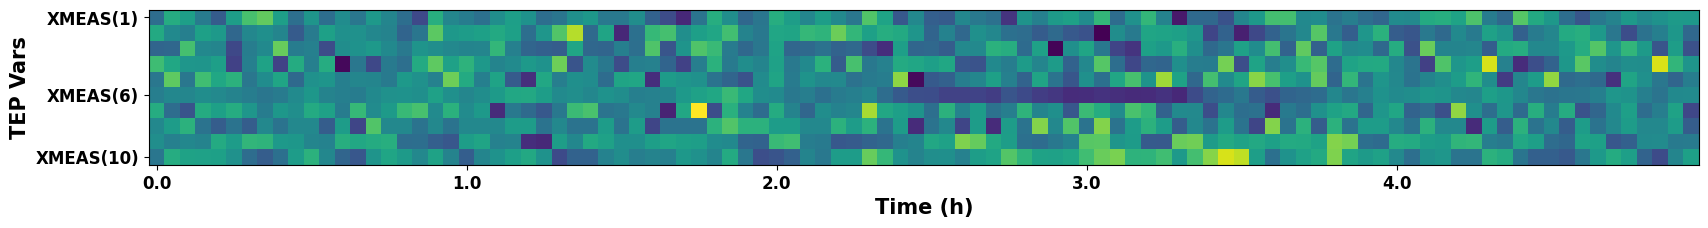

In [ ]:
ylabels_fd={'weight':'bold', 'size':15, 'family':'sans-serif'}
xlabels_fd={'weight':'bold', 'size':15, 'family':'sans-serif'}
title_fd={'weight':'bold','size':20,'family':'sans-serif'}
leg_fd={'weight':'bold','size':20,'family':'sans-serif'}
ticks_fd={'weight':'bold', 'size':12, 'family':'sans-serif'}

#select 10 TEP variables to plot
#select a window of 5 hours
#show the image of that data
#get a slice that is 1 hour long
data=noc_tr_norm.to_numpy()[:,PROCESS_VARS]
vars_subset=slice(1,11)
num_samples=int((5)*60/3)
data=data[:num_samples,vars_subset]
sequence=data[:20,:]

data=tf.transpose(data)
sequence=tf.transpose(sequence)


time_ticks=np.arange(0,100,20)
time_ticks_labels=[str(tick/20) for tick in time_ticks]
fig=plt.figure(figsize=(20,10))
plt.imshow(data)
ax=plt.gca()

ax.set_xlabel('Time (h)',fontdict=xlabels_fd)
ax.set_ylabel('TEP Vars',fontdict=ylabels_fd)
tick_locs=[0,5,9]
ax.set_yticks(tick_locs)
ytick_labels=[column for i,column in enumerate(columns) if i in tick_locs]
ax.set_yticklabels(ytick_labels,fontdict=ticks_fd)
ax.set_xticks(time_ticks)
ax.set_xticklabels(time_ticks_labels,fontdict=ticks_fd)

a,b=plt.xticks()

In [ ]:
ytick_labels=[column for i,column in enumerate(columns) if i in [0,10]]
ytick_labels

['XMEAS(1)', 'XMEAS(11)']

([], [])

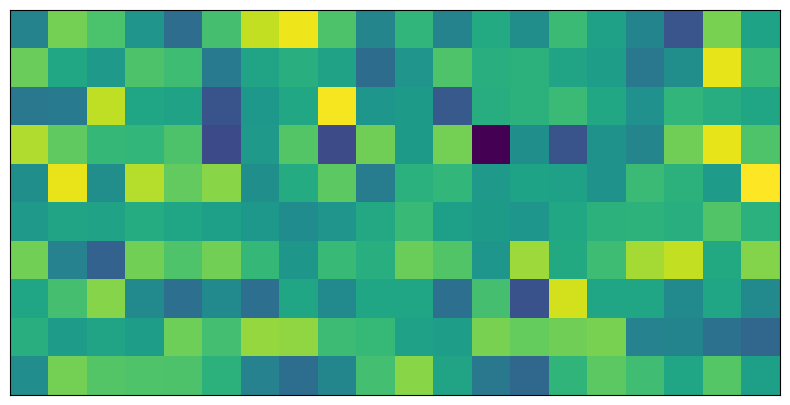

In [ ]:
plt.figure(figsize=(10,5))
plt.imshow(sequence)
plt.xticks([])
plt.yticks([])

<font size=5 >Normalizing the faulty data using the normalization parameters of the NOC training data </font>

In [ ]:
#creating a list storing the healthy and faulty (fault 1-21) data files
fault_files_pattern=base_path+'*_te.dat'
faulty_files=np.sort(glob(fault_files_pattern))[1:] #exclude the first file path as it is the noc data

#looping over the files and stroing them
fault_tep_data=[]
for i,file in enumerate(faulty_files):
    fi=pd.read_table(file,sep="\s+", names=columns)
    fi=apply_norm(data=[fi],norm_params=norm_params)[-1]
    #pdb.set_trace()
    fi=add_sampleid_column(add_faulttype_column(tep_data=fi,faultNumber=i+1))
    fault_tep_data.append(fi)



<font size=5 >DatasetCreator Class Def </font>

In [ ]:
class DataSetCreator():

    def __init__(self,data,in_width,out_width,shift=1,stride=None,batch_size=32):
        self.seq_width=in_width+shift
        self.in_width=in_width
        self.in_slcie=slice(in_width)
        self.out_slice=slice(self.seq_width-out_width,self.seq_width)

        if stride is not None:
            self.stride=stride
        else:
            self.stride=in_width

        self.data=data

        self.batch_size=batch_size

    def split(self,data):
        return data[:,self.in_slcie,:],data[:,self.out_slice,:]

    @property
    def dataset(self):
        ds=keras.utils.timeseries_dataset_from_array(data=self.data,targets=None,sequence_length=self.seq_width,sequence_stride=self.stride,batch_size=self.batch_size)#.prefetch()
        return ds.map(self.split)

<font size=6 color=teal> Training the PSSRNN </font>

In [ ]:
BATCH_SIZE=64

window_size=20
tep_dp=dp.TepDataPipe(input_width=window_size,label_width=window_size,shift=1,tr_data= noc_tr_norm, val_data= noc_val_norm, test_data=noc_ts_norm,target_names=None, sampling_rate= 1, batch_size = BATCH_SIZE, shuffle_flag  = False, seqeunce_stride=1) #TODO: I changed the sequence length from 30 minutes to 1 hour

In [ ]:
in_sample,out_sample=tep_dp.example

num_states=out_sample.shape[-1]
out_dim=num_states

st_layers_l=[keras.layers.Lambda(lambda x: x)]

ss_cell=SS_RNN.SsCell(num_states=num_states,output_dimension=out_dim,state_nn_layers=st_layers_l)

ss_layer=SS_RNN.SsLayer(ss_cell=ss_cell,instance_norm_flag=False)

ss_mdl=SS_RNN.SsRnnMdl(ss_layer)



2024-07-21 22:50:50.903158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [500,52]
	 [[{{node Placeholder/_0}}]]
2024-07-21 22:50:50.903727: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
/home/melbelta/Desktop/bayesian_ssrnn_venv/bayesian_ssrnn_venv/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code

<font size=5> Defining the decoder </font>

In [ ]:

target_shape=out_sample.shape[1:]
num_fc_units=tf.reduce_prod(target_shape)


d_l=[
     keras.layers.Conv2D(64,(3,3),activation='tanh',padding='same',activity_regularizer=keras.regularizers.L2(10e-4)),
     keras.layers.Conv2D(32,(3,3),activation='tanh',padding='same'),
     keras.layers.Conv2D(1,(3,3),activation='linear',padding='same',activity_regularizer=keras.regularizers.L2(10e-4))
    ]
fc_layer=[keras.layers.Input(shape=(num_states,)),keras.layers.Dense(units=num_fc_units,activation='tanh',kernel_regularizer=keras.regularizers.L2())]
reshape_4cnn_layer=keras.layers.Reshape(target_shape=target_shape+[1]) #addign an extra -dummy- dimension for the convolution
reshape_4out_layer=keras.layers.Reshape(target_shape=target_shape)

decoder=keras.Sequential(layers=[*fc_layer,reshape_4cnn_layer,*d_l,reshape_4out_layer])

<font size=5> Custom training loop that uses both prediction and reconstruction errors

In [ ]:
#intiial training using buitl-in functionalities to avoid the weight initialization problem I was facing

t_ae=enc.RnnLstmAutoEncoder(rnn_encoder=ss_mdl,lstm_decoder=decoder) #TODO: the class naming is off as other decoder can be used besides the LSTM. However, the encoder takes into account that the SSRNN model has two outputs

_=train.compile_and_fit(t_ae,tep_dp.train_ds,tep_dp.val_ds,loss_fn=keras.losses.MeanSquaredError(),metric=keras.metrics.MeanAbsoluteError(),max_epochs=4,patience=20,prof_call_back=None) #low number of epochs is set since the training is done to avoid the numerical instability cause by inappropriate initialization of the biases

Epoch 1/4


2024-07-21 22:50:51.294823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [500,52]
	 [[{{node Placeholder/_0}}]]
2024-07-21 22:50:51.295278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [500,52]
	 [[{{node Placeholder/_0}}]]


7/8 [=========================>....] - ETA: 0s - loss: 1.8911 - mean_absolute_error: 0.7988

2024-07-21 22:50:54.642712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [268]
	 [[{{node Placeholder/_8}}]]
2024-07-21 22:50:54.643051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [288,52]
	 [[{{node Placeholder/_0}}]]


8/8 [==============================] - 4s 114ms/step - loss: 1.8882 - mean_absolute_error: 0.8015 - val_loss: 1.8499 - val_mean_absolute_error: 0.8466
Epoch 2/4
8/8 [==============================] - 1s 81ms/step - loss: 1.6170 - mean_absolute_error: 0.8015 - val_loss: 1.6246 - val_mean_absolute_error: 0.8464
Epoch 3/4
8/8 [==============================] - 1s 76ms/step - loss: 1.4182 - mean_absolute_error: 0.8010 - val_loss: 1.4592 - val_mean_absolute_error: 0.8453
Epoch 4/4
8/8 [==============================] - 1s 76ms/step - loss: 1.2714 - mean_absolute_error: 0.7986 - val_loss: 1.3299 - val_mean_absolute_error: 0.8379


In [ ]:
#select one of the proposed decoders
 #this was the decoder that yielded the best results

#loss function selection
prediction_loss_function=lossmod.variational_log_likelihood
reconstruction_loss_function=keras.losses.MeanSquaredError()
#optimizer selection and paramters
l_rate=0.1 #TODO: Experiment with changing the learning rate
optimizer=keras.optimizers.legacy.Adam()
#perfromance metrics selection
pred_tr_metric=keras.metrics.MeanAbsoluteError()
pred_val_metric=keras.metrics.MeanAbsoluteError()
reconst_tr_metric=keras.metrics.MeanAbsoluteError()
reconst_val_metric=keras.metrics.MeanAbsoluteError()
# training settings
num_epochs=70
train_ds=tep_dp.train_ds.map(lambda i,j: (tf.cast(i,dtype='float32'),tf.cast(j,dtype='float32')))
val_ds=tep_dp.val_ds.map(lambda i,j: (tf.cast(i,dtype='float32'),tf.cast(j,dtype='float32')))
beta=0.5 #this is used to update the ss_rnn model paramters through the following (1-beta)*pred_grad+beta*reconst_grad TODO: This might not be useful since the order of magnitude of prediction loss (10e3) is significantly greater than than that of the reconstruction loss (10e-1)
#regularization parameters
alpha_l1=0.3*100
alpha_l2=0.01
#define a single training step for the join training of the SS_RNN model for prediction and encoding


@tf.function()
def train_step_joint(x,y):

    penalty= lambda weights: tf.reduce_sum([tf.linalg.norm(i,ord=2) for i in weights])
    with tf.GradientTape(persistent=True) as tp:
        #prediction loss calculation
        #pdb.set_trace()
        pred,latent_representation=ss_mdl(x) #TODO: Make sure the intended model is being trained
        pred_loss=prediction_loss_function(y,pred)
        pred_loss+=alpha_l1*(tf.reduce_sum(ss_mdl.ss_layer.ss_cell.A)+tf.reduce_sum(ss_mdl.ss_layer.ss_cell.B)) #impose sparsity via l1 regularization
        #reconstruction calculations
        reconst=decoder(latent_representation)
        reconst_loss=reconstruction_loss_function(y_true=x,y_pred=reconst)+alpha_l2*penalty(decoder.trainable_weights) #TODO: I might want to modify the regularization here if I choose to go with the FC-CNN decoder

        ss_rnn_loss=pred_loss+300*reconst_loss #TODO: Set a criteria for properly selecting the importance weight (NOTE: I have no clue why setting the weight to 300 worked)



    #get the gradients of both the SS_RNN and the LSTM_Decoder at once

    ss_rnn_grads=tp.gradient(ss_rnn_loss,ss_mdl.trainable_weights)
    decoder_grads=tp.gradient(reconst_loss,decoder.trainable_weights)
    #pdb.set_trace()
    #update the model paramters accordingly
    optimizer.apply_gradients(zip(ss_rnn_grads,ss_mdl.trainable_weights))  #optimizer.apply_gradients(zip(reconst_grads[0],ss_mdl_t.trainable_weights))
    optimizer.apply_gradients(zip(decoder_grads,decoder.trainable_weights))#+ss_mdl_t.trainable_weights)) #ss_mdl_t.trainable_weights+

    #optimizer.apply_gradients(zip(reconst_grads[1],decoder.trainable_weights)) #TODO: The problem starts from here

    #update the training performance metrics

    pred_tr_metric.update_state(y_true=y,y_pred=pred[0])
    reconst_tr_metric.update_state(y_true=x,y_pred=reconst)

    return pred_loss#,reconst_loss

@tf.function()
def val_step_joint(x,y):
    pred,latent_repr=ss_mdl(x)
    reconst=decoder(latent_repr)

    pred_val_metric.update_state(y_true=y,y_pred=pred[0])
    reconst_val_metric.update_state(y_true=x,y_pred=reconst)

def reset_metrics():
    pred_tr_metric.reset_state()
    pred_val_metric.reset_state()
    reconst_tr_metric.reset_state()
    reconst_val_metric.reset_state()


#trainign loop
for i in tf.range(num_epochs):
    for x,y in train_ds:
        _=train_step_joint(x,y)
        #print(_)
    for x,y in val_ds:
       val_step_joint(x,y)

    template='Epoch:{:03d}, pr_tr_MEA: {:.4f}, pr_val_MEA: {:.4f}, re_tr_MEA: {:.4f}, re_val_MEA: {:.4f}'
    print(template.format(i,pred_tr_metric.result(),pred_val_metric.result(),reconst_tr_metric.result(),reconst_val_metric.result()))

    reset_metrics()











2024-07-21 22:50:57.341004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [500,52]
	 [[{{node Placeholder/_0}}]]
2024-07-21 22:50:57.341353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [480]
	 [[{{node Placeholder/_8}}]]
2024-07-21 22:51:02.472994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Plac

Epoch:000, pr_tr_MEA: 0.8059, pr_val_MEA: 0.8360, re_tr_MEA: 0.7884, re_val_MEA: 0.8216
Epoch:001, pr_tr_MEA: 0.7739, pr_val_MEA: 0.8096, re_tr_MEA: 0.7710, re_val_MEA: 0.8079
Epoch:002, pr_tr_MEA: 0.7418, pr_val_MEA: 0.7807, re_tr_MEA: 0.7566, re_val_MEA: 0.7932
Epoch:003, pr_tr_MEA: 0.7095, pr_val_MEA: 0.7519, re_tr_MEA: 0.7410, re_val_MEA: 0.7862
Epoch:004, pr_tr_MEA: 0.6811, pr_val_MEA: 0.7274, re_tr_MEA: 0.7292, re_val_MEA: 0.7773
Epoch:005, pr_tr_MEA: 0.6594, pr_val_MEA: 0.7099, re_tr_MEA: 0.7244, re_val_MEA: 0.7760
Epoch:006, pr_tr_MEA: 0.6439, pr_val_MEA: 0.6968, re_tr_MEA: 0.7194, re_val_MEA: 0.7723
Epoch:007, pr_tr_MEA: 0.6310, pr_val_MEA: 0.6859, re_tr_MEA: 0.7158, re_val_MEA: 0.7709
Epoch:008, pr_tr_MEA: 0.6198, pr_val_MEA: 0.6754, re_tr_MEA: 0.7119, re_val_MEA: 0.7672
Epoch:009, pr_tr_MEA: 0.6089, pr_val_MEA: 0.6660, re_tr_MEA: 0.7083, re_val_MEA: 0.7658
Epoch:010, pr_tr_MEA: 0.6007, pr_val_MEA: 0.6595, re_tr_MEA: 0.7050, re_val_MEA: 0.7664
Epoch:011, pr_tr_MEA: 0.5949, pr

2024-07-21 22:52:12.055838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2024-07-21 22:52:12.056226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
/home/melbelta/PycharmProjects/IFDC-brnn/IFCC/models/encoders.py:402: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_k.set_yticklabels(ax_k.get_yticks(), fontdict=ylabels_fd)
/home/melbelta/PycharmProjects/IFDC-brnn/IFCC/models/encoders.py:411: UserWarning: FixedFormatter should only be used together with Fixe

[<Axes: title={'center': 'XMEAS(1)'}>,
 <Axes: title={'center': 'XMEAS(2)'}>,
 <Axes: title={'center': 'XMEAS(3)'}>,
 <Axes: title={'center': 'XMEAS(4)'}>,
 <Axes: title={'center': 'XMEAS(5)'}>,
 <Axes: title={'center': 'XMEAS(6)'}>,
 <Axes: title={'center': 'XMEAS(7)'}>,
 <Axes: title={'center': 'XMEAS(8)'}>,
 <Axes: title={'center': 'XMEAS(9)'}>,
 <Axes: title={'center': 'XMEAS(10)'}>,
 <Axes: title={'center': 'XMEAS(11)'}>,
 <Axes: title={'center': 'XMEAS(12)'}>,
 <Axes: title={'center': 'XMEAS(13)'}>,
 <Axes: title={'center': 'XMEAS(14)'}>,
 <Axes: title={'center': 'XMEAS(15)'}>,
 <Axes: title={'center': 'XMEAS(16)'}>,
 <Axes: title={'center': 'XMEAS(17)'}>,
 <Axes: title={'center': 'XMEAS(18)'}>,
 <Axes: title={'center': 'XMEAS(19)'}>,
 <Axes: title={'center': 'XMEAS(20)'}>,
 <Axes: title={'center': 'XMEAS(21)'}>,
 <Axes: title={'center': 'XMEAS(22)'}>,
 <Axes: title={'center': 'XMEAS(23)'}>,
 <Axes: title={'center': 'XMEAS(24)'}>,
 <Axes: title={'center': 'XMEAS(25)'}>,
 <Axes: t

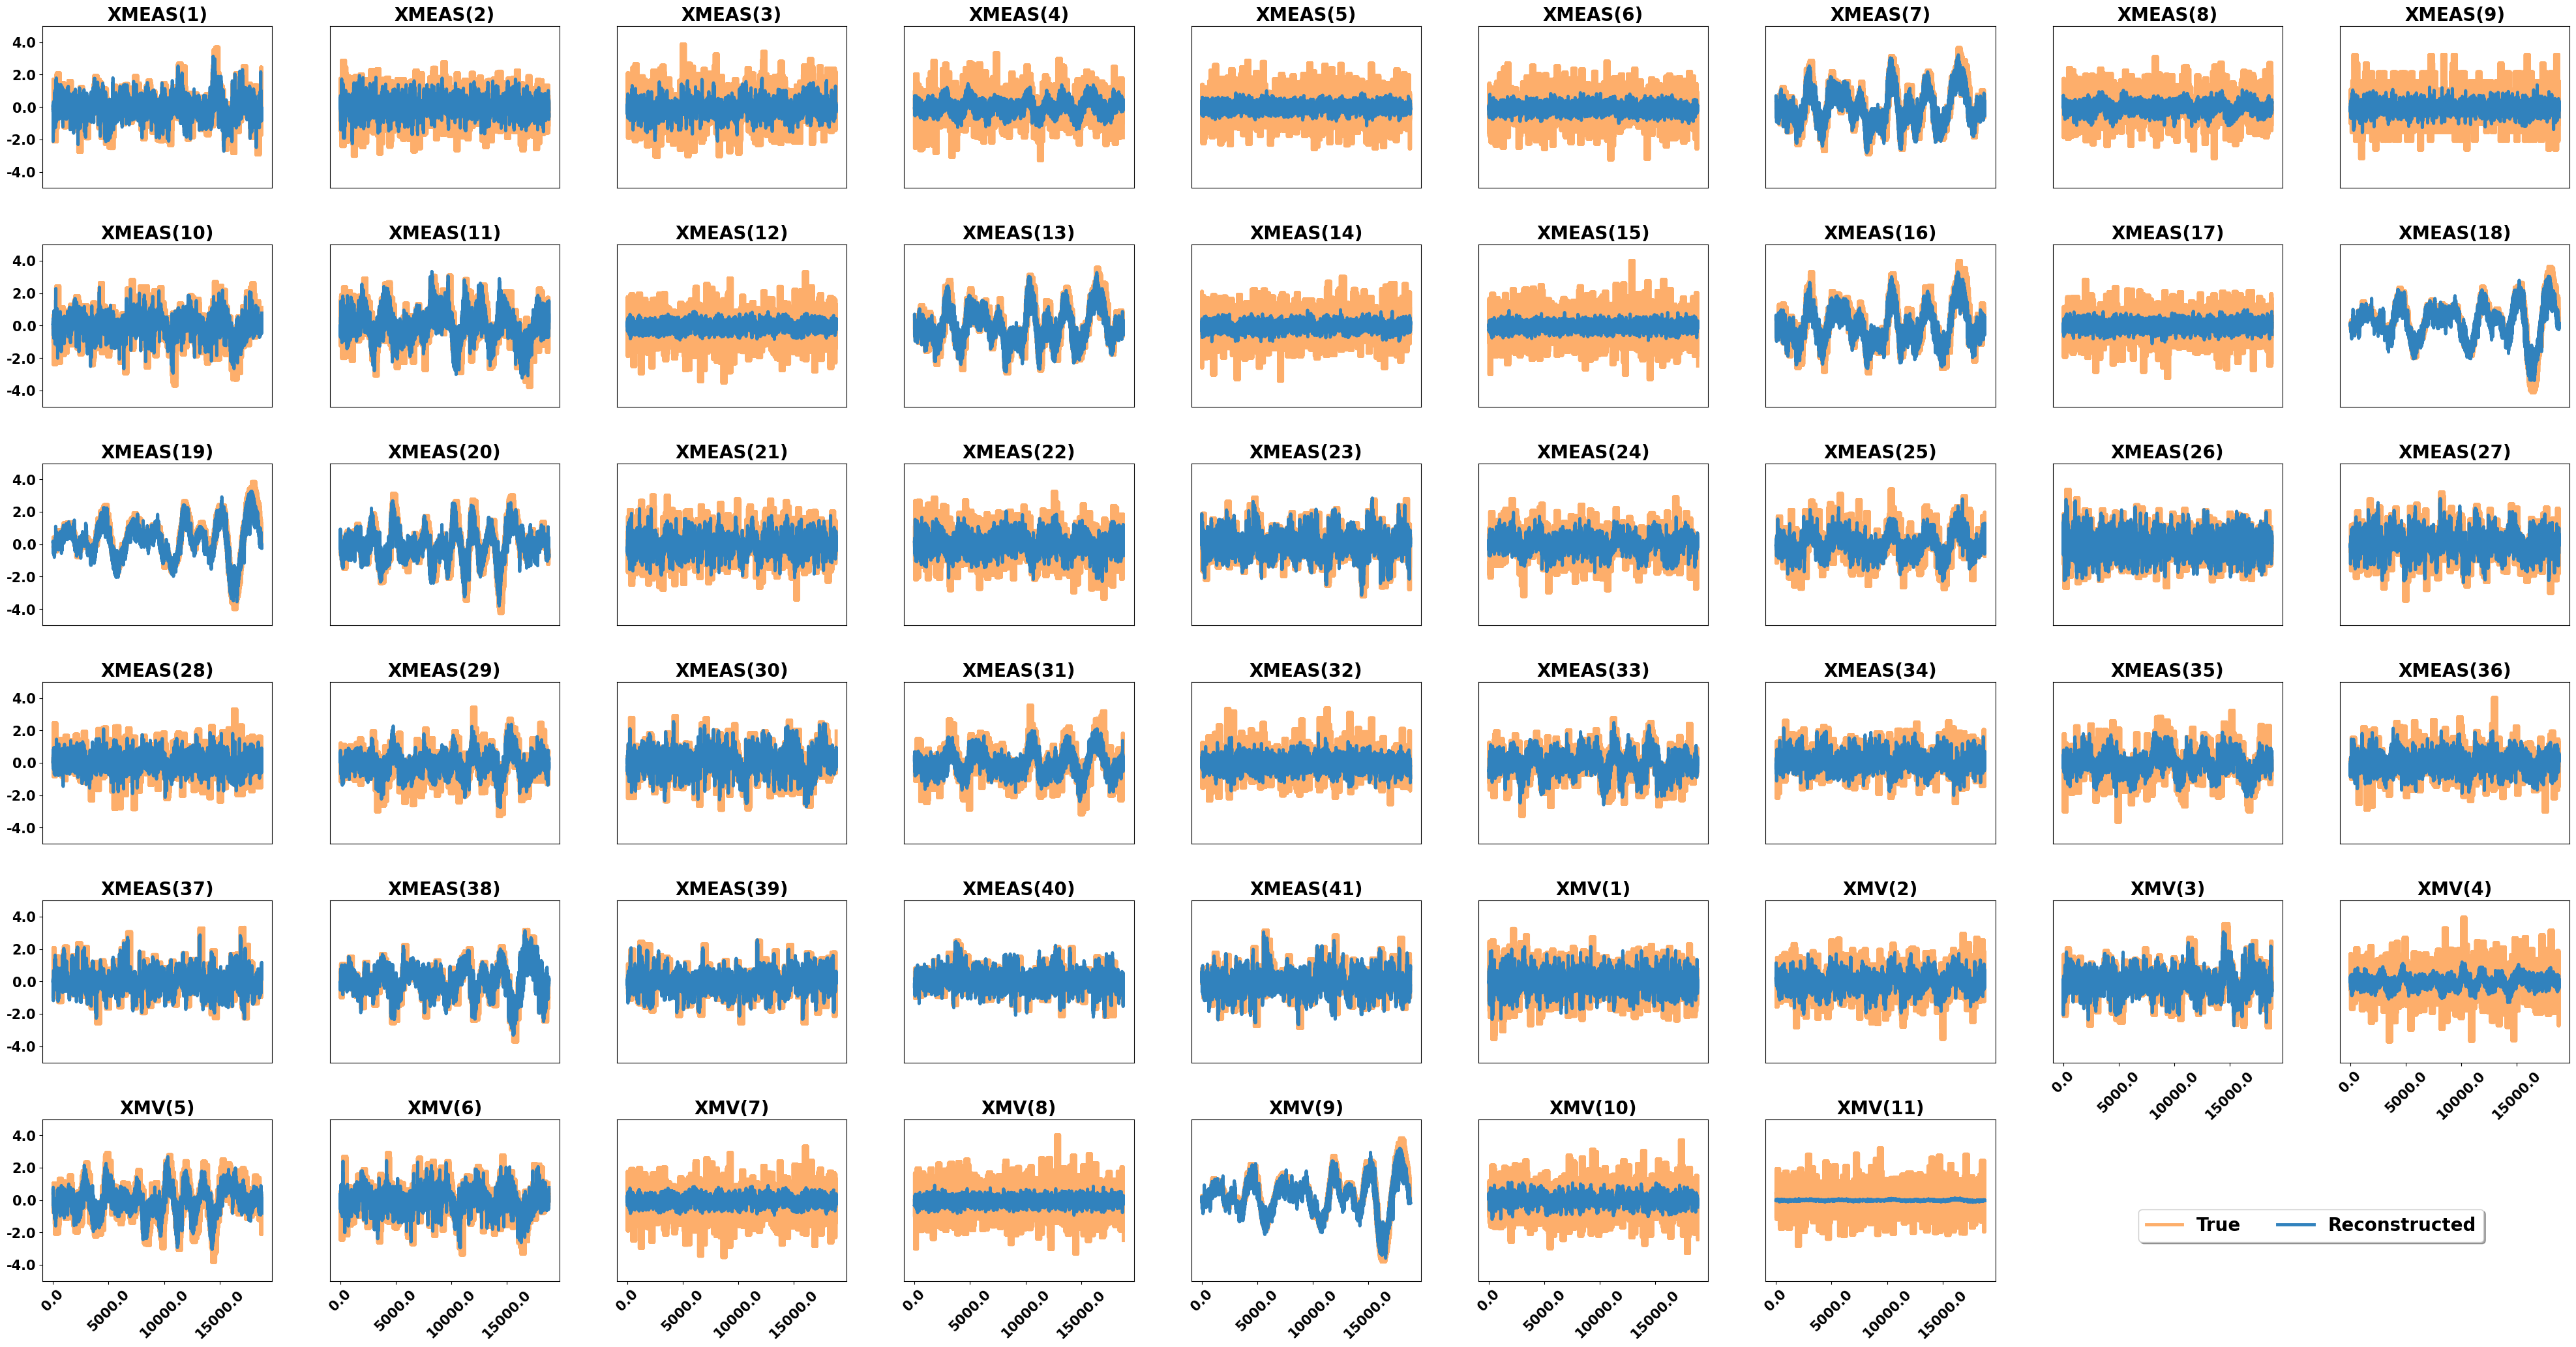

In [ ]:
t_ae=enc.RnnLstmAutoEncoder(rnn_encoder=ss_mdl,lstm_decoder=decoder) #TODO: the class naming is off as other decoder can be used besides the LSTM. However, the encoder takes into account that the SSRNN model has two outputs
enc.visualize_reconstruction(tep_dp.test_ds,t_ae,signal_names=columns,ylims=[-5,5])

<font size=6 color=teal> Fitting the joint distribution </font>

<font size=5> Through learning (optimization-based) </font>

In [ ]:

n=out_sample.shape[-1]

init_loc=np.array([0.]*n)
init_tril=tf.ones(shape=[n,n],dtype=tf.float32)
init_tril=tf.linalg.band_part(init_tril,-1,0)


dist=tfp.distributions.MultivariateNormalTriL(loc=tf.Variable(initial_value=init_loc,dtype=tf.float32,name='loc'),scale_tril=tf.Variable(initial_value=init_tril,name='cov_tril')) #tfp.util.TransformedVariable(initial_value=bi(init_diag),bijector=bi,name='scale-diag')
data=noc_tr_norm.to_numpy()[:,PROCESS_VARS]


optimizer=keras.optimizers.Adam(.6)

def loss_fn(data,dist):
    return -tf.reduce_sum(dist.log_prob(data))



num_epochs=2000
for i in range(num_epochs):

    with tf.GradientTape() as tp:
        loss=loss_fn(data,dist)

    print(loss)
    grads=tp.gradient(loss,dist.trainable_variables)
    optimizer.apply_gradients(zip(grads,dist.trainable_variables))

tf.Tensor(49359.453, shape=(), dtype=float32)
tf.Tensor(926683.25, shape=(), dtype=float32)
tf.Tensor(6145132.5, shape=(), dtype=float32)
tf.Tensor(662117.1, shape=(), dtype=float32)
tf.Tensor(141352.42, shape=(), dtype=float32)
tf.Tensor(168267.39, shape=(), dtype=float32)
tf.Tensor(155012.28, shape=(), dtype=float32)
tf.Tensor(124577.78, shape=(), dtype=float32)
tf.Tensor(105729.164, shape=(), dtype=float32)
tf.Tensor(94124.52, shape=(), dtype=float32)
tf.Tensor(86691.68, shape=(), dtype=float32)
tf.Tensor(82321.07, shape=(), dtype=float32)
tf.Tensor(80257.98, shape=(), dtype=float32)
tf.Tensor(79589.79, shape=(), dtype=float32)
tf.Tensor(79383.78, shape=(), dtype=float32)
tf.Tensor(79009.65, shape=(), dtype=float32)
tf.Tensor(78271.82, shape=(), dtype=float32)
tf.Tensor(77287.13, shape=(), dtype=float32)
tf.Tensor(76268.14, shape=(), dtype=float32)
tf.Tensor(75375.02, shape=(), dtype=float32)
tf.Tensor(74675.195, shape=(), dtype=float32)
tf.Tensor(74166.36, shape=(), dtype=float32)


<font size=5 color=red> I am facing a numerical issue when trying to implement this. Possible reasons are: </font>
<font size=4 color=red> - The way the pdf defined in tfp documentation is strange (am I missing something there?) </font>
<font size=4 color=red> - The constraint that the covariance matrix has to be positive defininte might be violated</font>

<font size=5> Emperically </font>

In [ ]:
eps=10**-5

j_mean=tf.reduce_mean(data,axis=0)
j_cov=empirical_covariance(data)
j_cov=j_cov+np.eye(n)*eps
j_dist=multivariate_normal(mean=j_mean,cov=j_cov)

<font size=5> Inspecting the fitted distribution </font>


/tmp/ipykernel_97995/2393402989.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20c', 20)
/tmp/ipykernel_97995/2393402989.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),fontdict=ylabels_fd)
/tmp/ipykernel_97995/2393402989.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_yticks(),fontdict=xlabels_fd)


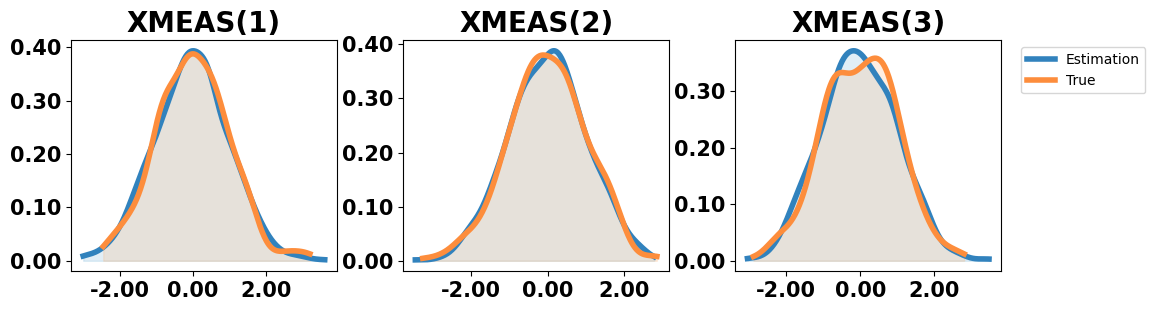

In [ ]:
from matplotlib.ticker import FormatStrFormatter

#setting plot paramters
#define a fontdic for the y-axis labels
ylabels_fd={'weight':'bold', 'size':15, 'family':'sans-serif'}
xlabels_fd={'weight':'bold', 'size':15, 'family':'sans-serif'}
title_fd={'weight':'bold','size':20,'family':'sans-serif'}
leg_fd={'weight':'bold','size':20,'family':'sans-serif'}


colors = plt.cm.get_cmap('tab20c', 20)

#setting the generated and actual samples
num_gen_samples=1000
process_vars=slice(1,-1)
noc_gen=j_dist.rvs(size=num_gen_samples)
noc_data=noc_tr_norm.to_numpy()[:,process_vars]

#
num_process_vars=noc_gen.shape[-1]

num_cols=3
num_rows=1#ceil(num_process_vars/num_cols)
#figure and gridspec
fig=plt.figure(figsize=(12,3))
gs=g_spec=gridspec.GridSpec(num_rows,num_cols)
#plot colors


#plotting loop
var_id=0


num_points=300
for i in range(num_rows):
    for j in range(num_cols):

        if var_id+1<=num_process_vars:
            ax=plt.subplot(gs[i,j])

            #get the variable distribution of the training NOC
            var_noc_gen=noc_gen[:,var_id]
            pdf_estimator=kde(var_noc_gen)
            var_range=np.linspace(min(var_noc_gen),max(var_noc_gen),num_points)
            noc_gen_pdf=pdf_estimator(var_range)

            ax.plot(var_range,noc_gen_pdf,color=colors(0),mew=4,label='Estimation',linewidth=4)
            ax.fill_between(var_range,noc_gen_pdf,color=colors(1),alpha=0.2)
            ax.set_title(columns[var_id])


            #get the variable distribution of the training NOC
            var_noc=noc_data[:,var_id]
            pdf_estimator=kde(var_noc)
            var_range=np.linspace(min(var_noc),max(var_noc),num_points)
            noc_pdf=pdf_estimator(var_range)

            ax.plot(var_range,noc_pdf,color=colors(5),mew=4,label='True',linewidth=4)
            ax.fill_between(var_range,noc_pdf,color=colors(6),alpha=0.2)
            ax.set_title(columns[var_id],fontdict=title_fd)


            ax.set_yticklabels(ax.get_yticks(),fontdict=ylabels_fd)
            ax.set_xticklabels(ax.get_yticks(),fontdict=xlabels_fd)

            ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            var_id+=1

            if i == 0 and j == num_cols - 1:
                        ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

            fig.subplots_adjust(wspace=0.25, hspace=0.35)


In [ ]:
import scipy as scy
scy.__version__

'1.11.1'

<font size=6 color=teal> Evaluating fault detection using only the joint distribution <font>


In [ ]:
def get_thresh_val(fpr,mahala):
    #this function takes a desired fpr and a sequence of mahala distance and returns the threshold value that will meet the fpr on the given sequence
    tot_num_samples=len(mahala)
    mahala_min=np.min(mahala)
    mahala_max=np.max(mahala)
    step_size=np.min(np.abs(np.diff(mahala)))
    thresh=mahala_min
    fpr_cond_met=False

    while not fpr_cond_met:

        thresh+=step_size

        num_samples_above_thresh= len(mahala[mahala >= thresh])
        current_fpr=num_samples_above_thresh/tot_num_samples

        if current_fpr<=fpr:
            fpr_cond_met=True

    return thresh,current_fpr




<font size=5> Setting a threshold value using the validation set </font>


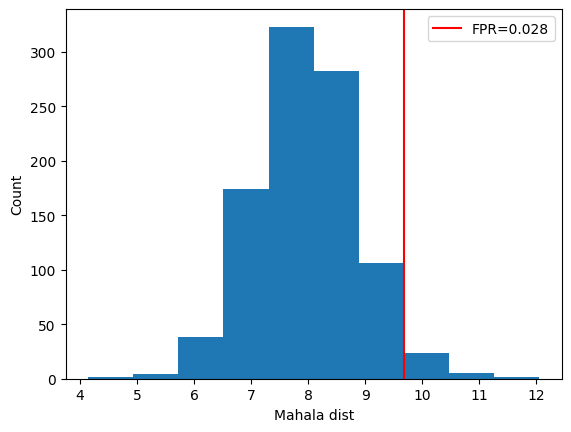

In [ ]:
def get_joint_mahala(j_dist,data):
    j_mean=j_dist.mean
    j_cov=j_dist.cov

    mahala=[mahalanobis(sample,j_mean,np.linalg.inv(j_cov)) for sample in data]
    return np.array(mahala)

#set the data
val_data=noc_ts_norm.to_numpy()[:,PROCESS_VARS]
#calculate Mahalanobis distance for each sample in the dataste
val_mahala=get_joint_mahala(j_dist,val_data)
plt.hist(val_mahala)
plt.xlabel('Mahala dist')
plt.ylabel('Count')

j_mahala_thresh,actual_fpr=get_thresh_val(fpr=0.03,mahala=val_mahala)

plt.axvline(x=j_mahala_thresh,color='red',label='FPR='+str(round(actual_fpr,3)))
plt.legend()



In [ ]:
round(actual_fpr,2)

0.03

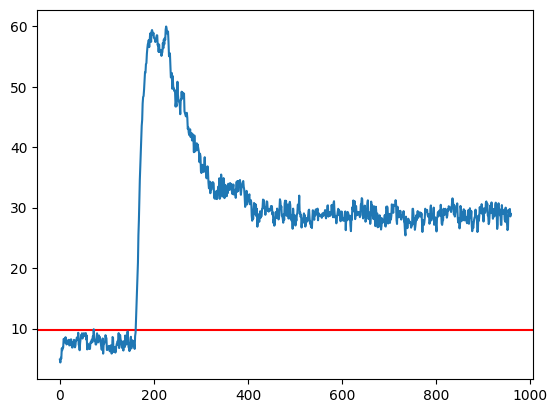

In [ ]:
fault_type=1
data=fault_tep_data[fault_type-1].to_numpy()[:,PROCESS_VARS]


mahala=get_joint_mahala(j_dist,data)

plt.axhline(y=j_mahala_thresh,color='red')
plt.plot(mahala)

<font size=6 color=teal> Evaluating fault detection using only the temporal distribution <font>


In [ ]:
#this function computed the mahal score for a sequence using the temporal distribution
def get_temp_mahala(ss_mdl,data):
    eps=10**-5 #for numerical stability
    #the data is of shape [time,features]
    data=tf.expand_dims(data,axis=0) #add a dummy dimension to represent a single batch
    pred=tf.squeeze(ss_mdl(data)[0]) #get the model prediction and remove the batch axis
    pred=tf.transpose(pred,perm=[1,0,2]) #transpose the prediction such that the time axis is first
    data=tf.squeeze(data)

    mahala=[mahalanobis(sample,temp_dist[0],np.linalg.inv(temp_dist[-1]+np.eye(n)*eps)) for sample,temp_dist in zip(data,pred)]
    return np.array(mahala)

/tmp/ipykernel_97995/3182171108.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),fontdict=ticks_fd)
/tmp/ipykernel_97995/3182171108.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(),fontdict=ticks_fd)


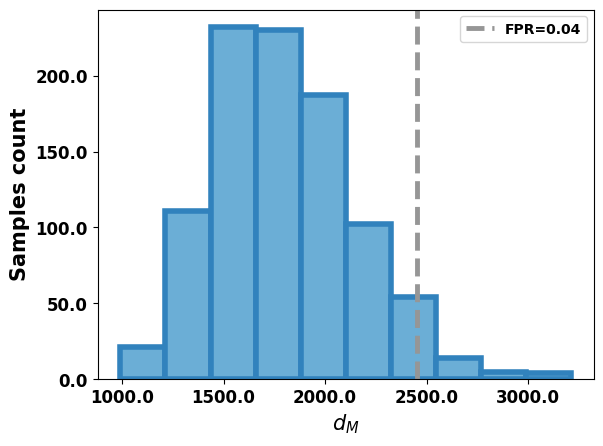

In [ ]:
data=noc_ts_norm.to_numpy()[:,PROCESS_VARS]
mahala=get_temp_mahala(ss_mdl,data)



ylabels_fd={'weight':'bold', 'size':15, 'family':'sans-serif'}
ticks_fd={'weight':'bold', 'size':12, 'family':'sans-serif'}
xlabels_fd={'weight':'bold', 'size':15, 'family':'sans-serif'}
title_fd={'weight':'bold','size':20,'family':'sans-serif'}
leg_fd={'weight':'bold','size':10,'family':'sans-serif'}


plt.hist(mahala,facecolor=colors(1),edgecolor=colors(0),linewidth=4)
plt.xlabel(r'$d_M$',fontdict=xlabels_fd)
plt.ylabel('Samples count',fontdict=ylabels_fd)
#plt.title('NOC validation set Mahalanobis distribution',fontdict=title_fd)
ax=plt.gca()
ax.set_yticklabels(ax.get_yticks(),fontdict=ticks_fd)
ax.set_xticklabels(ax.get_xticks(),fontdict=ticks_fd)


t_mahala_thresh,actual_fpr=get_thresh_val(fpr=0.04,mahala=mahala)

v_line=ax.axvline(x=t_mahala_thresh,color=colors(17),linestyle='--',linewidth=3.5,label='FPR='+str(round(actual_fpr,3)))
ax.legend(handles=[v_line],prop=leg_fd)

In [ ]:
#using the temporal correlation for fault detection
fault_type=10
data=fault_tep_data[fault_type-1].to_numpy()[:,PROCESS_VARS]


mahala=get_temp_mahala(ss_mdl,data=data)

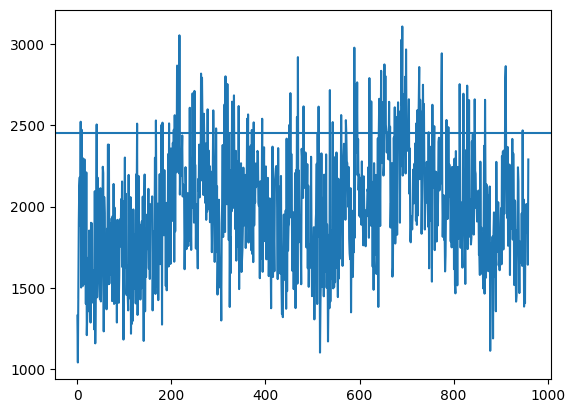

In [ ]:
plt.axhline(y=t_mahala_thresh)
plt.plot(mahala)

<font size=6 color=teal> Evaluating fault detection using both distributions <font>


/tmp/ipykernel_97995/272020574.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),fontdict=ticks_fd)
/tmp/ipykernel_97995/272020574.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(),fontdict=ticks_fd)


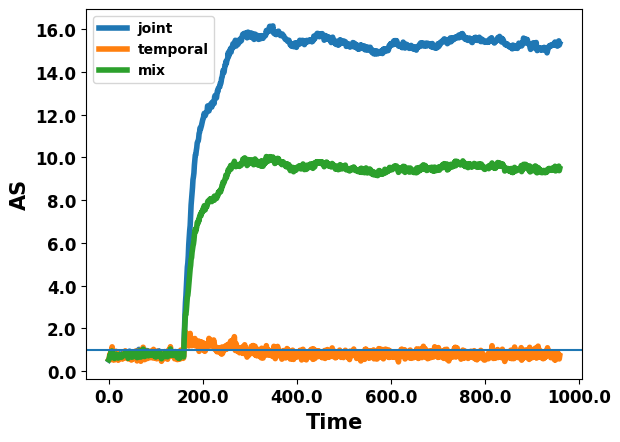

In [ ]:

ylabels_fd={'weight':'bold', 'size':15, 'family':'sans-serif'}
ticks_fd={'weight':'bold', 'size':12, 'family':'sans-serif'}
xlabels_fd={'weight':'bold', 'size':15, 'family':'sans-serif'}
title_fd={'weight':'bold','size':20,'family':'sans-serif'}
leg_fd={'weight':'bold','size':10,'family':'sans-serif'}


#visualizing both anomaly scores simultaneously
fault_type=5
data=fault_tep_data[fault_type-1].to_numpy()[:,PROCESS_VARS]

j_mahala=get_joint_mahala(j_dist,data)/j_mahala_thresh
t_mahala=get_temp_mahala(ss_mdl,data)/t_mahala_thresh
alpha=0.6
mix_mahala=alpha*(j_mahala)+(1-alpha)*t_mahala

h1=plt.plot(j_mahala,label='joint',linewidth=4)
h2=plt.plot(t_mahala,label='temporal',linewidth=4)
h3=plt.plot(mix_mahala,label='mix',linewidth=4)


plt.xlabel('Time',fontdict=xlabels_fd)
plt.ylabel('AS',fontdict=ylabels_fd)


ax=plt.gca()
ax.set_yticklabels(ax.get_yticks(),fontdict=ticks_fd)
ax.set_xticklabels(ax.get_xticks(),fontdict=ticks_fd)


plt.axhline(y=1)
plt.legend(prop=leg_fd)

<font size=5> Defining functions for fault detection performance analysis </font>

In [ ]:

def analyze_sample(mean_vector,cov_vector,actual_sample):
    return (actual_sample-mean_vector)/cov_vector


def locate_fault_source(subsequence_z_score):
    #subsequence_z_score this is an l x k matrix storing the z score of a subsequence of length l
    np.mean(subsequence_z_score,)

def detect_faults(pred,target,mahala_thresh,z_thresh):
        #pred: a 2 x l x k matrix array corresponding to the prediction of k the process variables over a period l
        #target: an l x k the corresponding actual values
        l=pred.shape[1] #the first axis stores the mean and covariance matrix of the prediction distribution
        k=pred.shape[-1] #number of process variables
        m=[]
        f=[]
        z=[]
        s=[]
        noise_std=10**-4
        for i in range(l):
            mean=pred[0,i,:]
            cov=pred[1,i,:]
            cov_mat=outer(cov,cov)
            #pdb.set_trace()
            cov_mat+=noise_std*np.eye(k)  #there seem to be instability caused by the cov having entries close to zero. The work of Sun et al describes this parameter as the "intrensic noise"
            sample=target[i]
            mahala_dist=mahalanobis(mean,sample,np.linalg.inv(cov_mat))
            m.append(mahala_dist)
            f.append(mahala_dist>=mahala_thresh)
            z_score=analyze_sample(mean,cov,sample)
            z.append(z_score)
            source_idx=abs(z_score)>=z_thresh
            s.append(source_idx)

        return m,f,z,s

def align_sequences(pred_data,target_data,time_overhead):
    #pred_data: l x k array storing the predictions of the ss_rnn model
    #target_data: l x k array storing the actual process measurements
    return pred_data[:,time_overhead:], target_data[:-time_overhead]

def is_faulty(anomaly_score,thresh):
    return anomaly_score > thresh


<font size=6 color=teal> Obtaining the fault detection metrics results </font>

In [ ]:
fault_metrics=[]

for i,data in enumerate(fault_tep_data):

    #setting the fault data
    fault_type=i+1
    data=data.to_numpy()[:,PROCESS_VARS]

    #obtaining Mahalanobis distances using the temporal and static distributions
    t_mahala=get_temp_mahala(ss_mdl,data)
    j_mahala=get_joint_mahala(j_dist,data)
    #normalizing the Mahalanobis distances using the corresponding threshold values
    t_mahala/=t_mahala_thresh
    j_mahala/=j_mahala_thresh

    #setting alpha (the temporal distribution importance weight)
    alpha=0.4

    #calculating the anomaly score
    anomaly_score=alpha*t_mahala+(1-alpha)*j_mahala

    #detect fault samples
    pred_fs=is_faulty(anomaly_score,thresh=1.0)

    #get the true samples state
    true_fs=tepmanip.get_samples_fault_state(tep_data=data,fault_injection_time=8)

    #get the fault detection metrics
    fault_metrics.append(fd.get_fault_detection_metrics(true_fs,pred_fs))




In [ ]:
perf_metrics_names=['fpr','fnr','sensitivity','specifity','accuracy']
fault_detection_results=pd.DataFrame(np.concatenate([fault_metrics]),columns=perf_metrics_names)*100
fault_detection_results.insert(loc=0,column='fault type',value=np.arange(1,21+1))
fault_detection_results=fault_detection_results.drop(['sensitivity','specifity'],axis=1)
print(fault_detection_results)

    fault type    fpr     fnr    accuracy
0            1  1.250   0.125   99.687500
1            2  1.250   1.375   98.645833
2            3  3.125  97.875   17.916667
3            4  1.250   0.000   99.791667
4            5  1.250   0.000   99.791667
5            6  0.000   0.000  100.000000
6            7  0.000   0.000  100.000000
7            8  0.000   2.250   98.125000
8            9  3.750  97.250   18.333333
9           10  0.000  17.125   85.729167
10          11  1.875  24.500   79.270833
11          12  1.875   0.125   99.583333
12          13  0.000   4.750   96.041667
13          14  0.000   0.000  100.000000
14          15  0.625  96.250   19.687500
15          16  2.500  16.375   85.937500
16          17  1.250   4.875   95.729167
17          18  1.250  10.125   91.354167
18          19  0.625  20.750   82.604167
19          20  0.625  13.125   88.958333
20          21  0.625  52.875   55.833333


In [ ]:
fault_detection_results.loc[~fault_detection_results['fault type'].isin([3, 9, 15]),'accuracy'].mean()

92.06018518518518

In [ ]:
fault_detection_results['fault type'].isin([3, 9, 15])


0     False
1     False
2      True
3     False
4     False
5     False
6     False
7     False
8      True
9     False
10    False
11    False
12    False
13    False
14     True
15    False
16    False
17    False
18    False
19    False
20    False
Name: fault type, dtype: bool

<font size=6 color=teal> Feature extraction using the latent representation and the deviation information </font>
<font size=4> Steps: </font>
1- Conver the fault time-series data to a dataset of sequences using the DataSplitter class
2- Pass the sequences through the model to obtain the latent representation



In [ ]:
class DataSplitter():  #TODO: I have two definitons of the same class

    def __init__(self,in_index,out_index,process_vars):
        self.in_index=in_index
        self.out_index=out_index
        self.process_vars=process_vars
    def split(self,data):
        return data[:,self.in_index,self.process_vars], data[:,self.out_index,self.process_vars]

def analyze_sample_using_static_noc_dist(samples,dist):
    #samples are used to denote the sequence
    mu=dist.mean
    std=np.sqrt(np.diag(dist.cov))

    return (samples-mu)/std

def analyze_sample_using_temporal_noc_dist(samples,temp_dist_seq):
    '''
    :param samples: used to denote the sequence, for each sample in the sequence there will be a corresponding distribution
    :param temp_dist_pseq: a seqeuce of temporal (MultivariateNomralDiag) distribution parameters (mean and scale_diag matrices for a given number of time steps)
    :return: the z-score of the sequence
    '''

    #step 1: get the distribution mean (for all samples)
    mu=temp_dist_seq[0]
    scale_diag=temp_dist_seq[-1]
    std=scale_diag**2 #I showed that the std can be obtained by taking the square of the scale_diag (check tfp documentation). I also verified it numerically

    return (samples-mu)/std

    #step 2: get the distribution std (for all samples)

In [ ]:
#converting the time-series data into datasets of sequences
in_width=20
out_width=20
shift=1
stride=1  #setting the stride width to in_width prevents overlapping sequences
seq_width=in_width+shift
in_index=slice(0,in_width)
out_index=slice(shift,seq_width)
process_vars=slice(0,54) #this will include all if the tep variables (sample id and fault type are included)


cast= lambda i,j: (tf.cast(i,dtype=tf.float32), tf.cast(j,dtype=tf.float32))

splitter=DataSplitter(in_index,out_index,process_vars)


faulty_as_dataset_l=[] #this list stores each fault type data as a dataset that splits a sequence into input and output
for ith_fault_data in [noc_ts_norm]+fault_tep_data:
    num_samples=ith_fault_data.shape[0]

    fault_injection_time=8
    fault_samples_idx=tepmanip.get_samples_fault_state(ith_fault_data,fault_injection_time=fault_injection_time)


    ts=keras.utils.timeseries_dataset_from_array(ith_fault_data.iloc[fault_samples_idx,:],targets=None,sequence_length=seq_width,sequence_stride=stride,batch_size=num_samples)
    ts=ts.map(splitter.split).map(cast)
    faulty_as_dataset_l.append(ts)



in_width=20
out_width=20
shift=1
stride=in_width #setting the stride width to in_width prevents overlapping sequences
seq_width=in_width+shift
in_index=slice(0,in_width)
out_index=slice(shift,seq_width)
process_vars=slice(0,54)


faulty_as_dataset_l_no_overlap=[] #this list stores each fault type data as a dataset that splits a sequence into input and output
for ith_fault_data in [noc_ts_norm]+fault_tep_data:
    num_samples=ith_fault_data.shape[0]

    fault_injection_time=8
    fault_samples_idx=tepmanip.get_samples_fault_state(ith_fault_data,fault_injection_time=fault_injection_time)


    ts=keras.utils.timeseries_dataset_from_array(ith_fault_data.iloc[fault_samples_idx,:],targets=None,sequence_length=seq_width,sequence_stride=stride,batch_size=num_samples)
    ts=ts.map(splitter.split).map(cast)
    faulty_as_dataset_l_no_overlap.append(ts)


In [ ]:
#obtaining the latent representation

faults_lat_rep=[]
fault_type_l=[]
for i,ith_fault_dataset in enumerate(faulty_as_dataset_l):
    data=ith_fault_dataset.get_single_element()[0][:,:,PROCESS_VARS]
    num_sequences=data.shape[0]
    _,lat_rep=ss_mdl(data)
    faults_lat_rep.append(lat_rep)
    fault_type_l.append([i]*num_sequences)

faults_lat_rep=np.concatenate(faults_lat_rep)
fault_type_l=np.concatenate(fault_type_l)


In [ ]:
#obtaining the static deviation information


num_process_vars=len(columns) #TODO: Modify the code such that this is determined from the data


num_faults=len(faulty_as_dataset_l) #faulty_as_dataset stores the samples after the 8 hours mark (when the fault is introduced)

#create a tensor array to store the different faults z-score info
faults_zsc_mean_data=tf.TensorArray(dtype=tf.float32,size=num_faults)
faults_zsc_std_data=tf.TensorArray(dtype=tf.float32,size=num_faults)

#fault_type_l=[]

for i,fi_ds in enumerate(faulty_as_dataset_l): #loop over the fault types

    ith_fault_data=fi_ds.get_single_element()[-1]
    #fault_type=ith_fault_data[0,0,-1]
    ith_fault_data=ith_fault_data[:,:,PROCESS_VARS]
    num_sequences=ith_fault_data.shape[0]

    #update the fault type list
    # fi_type=int(fault_type)*tf.ones(shape=[num_sequences],dtype=tf.int32)
    # fault_type_l.append(fi_type)


    zsc_mu=[]
    zsc_std=[]
    for seq_id in range(num_sequences):
        targ_seq=ith_fault_data[seq_id]
        z_score=analyze_sample_using_static_noc_dist(samples=targ_seq,dist=j_dist) #the output has the shape [time,features]

        #get the mean of the z-score and the std (the mean is computed along the time axis)
        z_score_mu=tf.reduce_mean(z_score,axis=0)
        z_score_std=tf.math.reduce_std(z_score,axis=0)

        zsc_mu.append(z_score_mu)
        zsc_std.append(z_score_std)

    faults_zsc_mean_data=faults_zsc_mean_data.write(i,np.concatenate([zsc_mu],axis=0))
    faults_zsc_std_data=faults_zsc_std_data.write(i,np.concatenate([zsc_std],axis=0))

faults_zsc_mean_data=faults_zsc_mean_data.stack()
faults_zsc_mean_data=tf.reshape(faults_zsc_mean_data,shape=[-1,num_process_vars])

faults_zsc_std_data=faults_zsc_std_data.stack()
faults_zsc_std_data=tf.reshape(faults_zsc_std_data,shape=[-1,num_process_vars])

#faults_type_data=np.concatenate(fault_type_l,axis=0)
#create
faults_dev_info=np.concatenate([faults_zsc_mean_data,faults_zsc_std_data],axis=1)






In [ ]:

pf_time_series=[]
pf_zscore=[]

pf_time_series_no_overlap=[]
pf_zscore_no_overlap=[]

window_size=20

for fault_data in faulty_as_dataset_l:
    in_data,out_data=fault_data.get_single_element()
    in_data,out_data=in_data[:,:,PROCESS_VARS],out_data[:,:,PROCESS_VARS]
    pred,_=ss_mdl(in_data)
    #pdb.set_trace()
    pf=out_data-pred[0] #use the prediction mean
    pf_time_series.append(pf)
    #compute the z-score
    zscore=pf/(pred[1]**2) #it turns out I did not need the function "analyze_sample_using_temporal_noc_dist" after all
    pf_zscore.append(zscore)



#I added this part to enable aalyzing the clusters using the residual timeseries data. Why? one of the steps is reshaping the sequences [bathc,time,features] into [time,features] which assumes non-overlapping data as it applies a filter to get rid of the noise. I expect that using overlapping set will be problematic. Also, I added this part after discovering that the residual z-score should not be used (that is why the loop does not append data to pf_zscore_no_overlap)

for fault_data in faulty_as_dataset_l_no_overlap:
    in_data,out_data=fault_data.get_single_element()
    in_data,out_data=in_data[:,:,PROCESS_VARS],out_data[:,:,PROCESS_VARS]
    pred,_=ss_mdl(in_data)
    #pdb.set_trace()
    pf=out_data-pred[0] #use the prediction mean
    pf_time_series_no_overlap.append(pf)





<font size=5 color=black> The following summarizes the temproal residual sequences </font>
<font size=4>  </font>


In [ ]:

#create a tensor array to store the different faults temporal residual info (pf stands for plant_model_under_fault)
faults_pf_mean_data=tf.TensorArray(dtype=tf.float32,size=num_faults)
faults_pf_std_data=tf.TensorArray(dtype=tf.float32,size=num_faults)


for i,pfi in enumerate(pf_time_series): #loop over the fault types


    num_sequences=pfi.shape[0]

    #update the fault type list
    # fi_type=int(fault_type)*tf.ones(shape=[num_sequences],dtype=tf.int32)
    # fault_type_l.append(fi_type)


    pfi_mu=[]
    pfi_std=[]
    for seq_id in range(num_sequences):

        res_seq=pfi[seq_id] #the output has the shape [time,features]

        #get the mean of the z-score and the std (the mean is computed along the time axis)
        res_seq_mu=tf.reduce_mean(res_seq,axis=0)
        res_seq_std=tf.math.reduce_std(res_seq,axis=0)

        pfi_mu.append(res_seq_mu)
        pfi_std.append(res_seq_std)

    faults_pf_mean_data=faults_pf_mean_data.write(i,np.concatenate([pfi_mu],axis=0))
    faults_pf_std_data=faults_pf_std_data.write(i,np.concatenate([pfi_std],axis=0))



faults_pf_mean_data=faults_pf_mean_data.stack()
faults_pf_mean_data=tf.reshape(faults_pf_mean_data,shape=[-1,num_process_vars])

faults_pf_std_data=faults_pf_std_data.stack()
faults_pf_std_data=tf.reshape(faults_pf_std_data,shape=[-1,num_process_vars])

#faults_type_data=np.concatenate(fault_type_l,axis=0)
#create
faults_pf_dev_info=np.concatenate([faults_pf_mean_data,faults_pf_std_data],axis=1) #TODO: Chnage the name of the deviation info to indictae the two different type, or add an if condition to select one type at a time

<font size=5 color=black> The following summarizs the temproal residual (z-score) sequences </font>
<font size=4>  </font>



In [ ]:


#create a tensor array to store the different faults z-score info
faults_pf_zsc_mean_data=tf.TensorArray(dtype=tf.float32,size=num_faults)
faults_pf_zsc_std_data=tf.TensorArray(dtype=tf.float32,size=num_faults)


for i,pfi_zscore in enumerate(pf_zscore): #loop over the fault types


    num_sequences=pfi_zscore.shape[0]

    #update the fault type list
    # fi_type=int(fault_type)*tf.ones(shape=[num_sequences],dtype=tf.int32)
    # fault_type_l.append(fi_type)


    zsc_mu=[]
    zsc_std=[]
    for seq_id in range(num_sequences):

        z_score=pfi_zscore[seq_id] #the output has the shape [time,features]

        #get the mean of the z-score and the std (the mean is computed along the time axis)
        z_score_mu=tf.reduce_mean(z_score,axis=0)
        z_score_std=tf.math.reduce_std(z_score,axis=0)

        zsc_mu.append(z_score_mu)
        zsc_std.append(z_score_std)

    faults_pf_zsc_mean_data=faults_pf_zsc_mean_data.write(i,np.concatenate([zsc_mu],axis=0))
    faults_pf_zsc_std_data=faults_pf_zsc_std_data.write(i,np.concatenate([zsc_std],axis=0))



faults_pf_zsc_mean_data=faults_pf_zsc_mean_data.stack()
faults_pf_zsc_mean_data=tf.reshape(faults_pf_zsc_mean_data,shape=[-1,num_process_vars])

faults_pf_zsc_std_data=faults_pf_zsc_std_data.stack()
faults_pf_zsc_std_data=tf.reshape(faults_pf_zsc_std_data,shape=[-1,num_process_vars])

#faults_type_data=np.concatenate(fault_type_l,axis=0)
#create
faults_pf_zsc_dev_info=np.concatenate([faults_pf_zsc_mean_data,faults_pf_zsc_std_data],axis=1) #TODO: Chnage the name of the deviation info to indictae the two different type, or add an if condition to select one type at a time

In [ ]:
print("The number of summarized temporal residual sequences (for all faults) is: {}".format(faults_zsc_mean_data.shape[0]))
print("There are {} entries in the fault type list".format(len(fault_type_l)))
assert len(fault_type_l)==faults_zsc_mean_data.shape[0], "Something is wrong, the number of fault types entries do not ,atch the number of sequences "

The number of summarized temporal residual sequences (for all faults) is: 17160
There are 17160 entries in the fault type list


In [ ]:
#for comparison purposes I will limit the faults to the following types [1,2,4,6,7,11,13,14,17,19,20] (The same fault types from Zheng's etal work)
faults_2clus=[1,2,4,6,7,11,13,14,17,18,19,20] #I added 18 temporarily

idx_f2c=[type in faults_2clus for type in fault_type_l]

f2c_lat_rep=faults_lat_rep[idx_f2c,:]
f2c_dev_info=faults_dev_info[idx_f2c,:] #TODO: rename this to stat_res (static residual = deviation info)
f2c_temp_res=faults_pf_dev_info[idx_f2c,:]
f2c_temp_res_zsc=faults_pf_zsc_dev_info[idx_f2c,:]
f2c_type=fault_type_l[idx_f2c]

<font size=6 color=teal> Clustering using t-SNE and DBSCAN </font>

<font size=5> t-SNE </font>

In [ ]:
#dev info
X_tsne_dev=TSNE(n_components=2,perplexity=30,init='random').fit_transform(f2c_dev_info)

In [ ]:
#lat rep
X_tsne_lat=TSNE(n_components=2,perplexity=30,init='random').fit_transform(f2c_lat_rep)

In [ ]:
#both
# faults_all_both=np.concatenate([faults_dev_info,faults_lat_rep],axis=1)
# print(faults_all_both.shape)
# X_tsne_both=TSNE(n_components=2,perplexity=30,init='random').fit_transform(f2c_dev_info)

<font size=5 color=teal> Based on the clustering results using both the deviation info (static residual) and the latent representation might not be very useful </font>

In [ ]:
X_tsne_temp_res=TSNE(n_components=2,perplexity=30,init='random').fit_transform(f2c_temp_res)

In [ ]:
X_tsne_temp_res_zsc=TSNE(n_components=2,perplexity=30,init='random').fit_transform(f2c_temp_res_zsc)

<font size=5> DBSCAN </font>

In [ ]:
#dev info
eps=6
min_samples=20
x_dbscan_dev=DBSCAN(eps=eps,min_samples=min_samples).fit(X_tsne_dev)


In [ ]:
#lat rep
eps=6
min_samples=14
x_dbscan_lat=DBSCAN(eps=eps,min_samples=min_samples).fit(X_tsne_lat)


In [ ]:
#both
# eps=6
# min_samples=13
# x_dbscan_both=DBSCAN(eps=eps,min_samples=min_samples).fit(X_tsne_both)

In [ ]:
#temp residual
eps=6
min_samples=13
x_dbscan_temp_res=DBSCAN(eps=eps,min_samples=min_samples).fit(X_tsne_temp_res)

In [ ]:
#temp residual zsc
eps=6
min_samples=13
x_dbscan_temp_res_zsc=DBSCAN(eps=eps,min_samples=min_samples).fit(X_tsne_temp_res_zsc)

<font size=5> Visualizing the results </font>

/tmp/ipykernel_97995/992421166.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors=plt.cm.get_cmap('tab20',num_faults)
/tmp/ipykernel_97995/992421166.py:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X_tsne_lat[ith_fault_idx,0],X_tsne_lat[ith_fault_idx,1],label='f'+str(f_type),c=colors(f_type),s=30,linewidths=2)
/tmp/ipykernel_97995/992421166.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),fontdict=ylabels_fd)
/tmp/ipykernel_97995/992421166.py:

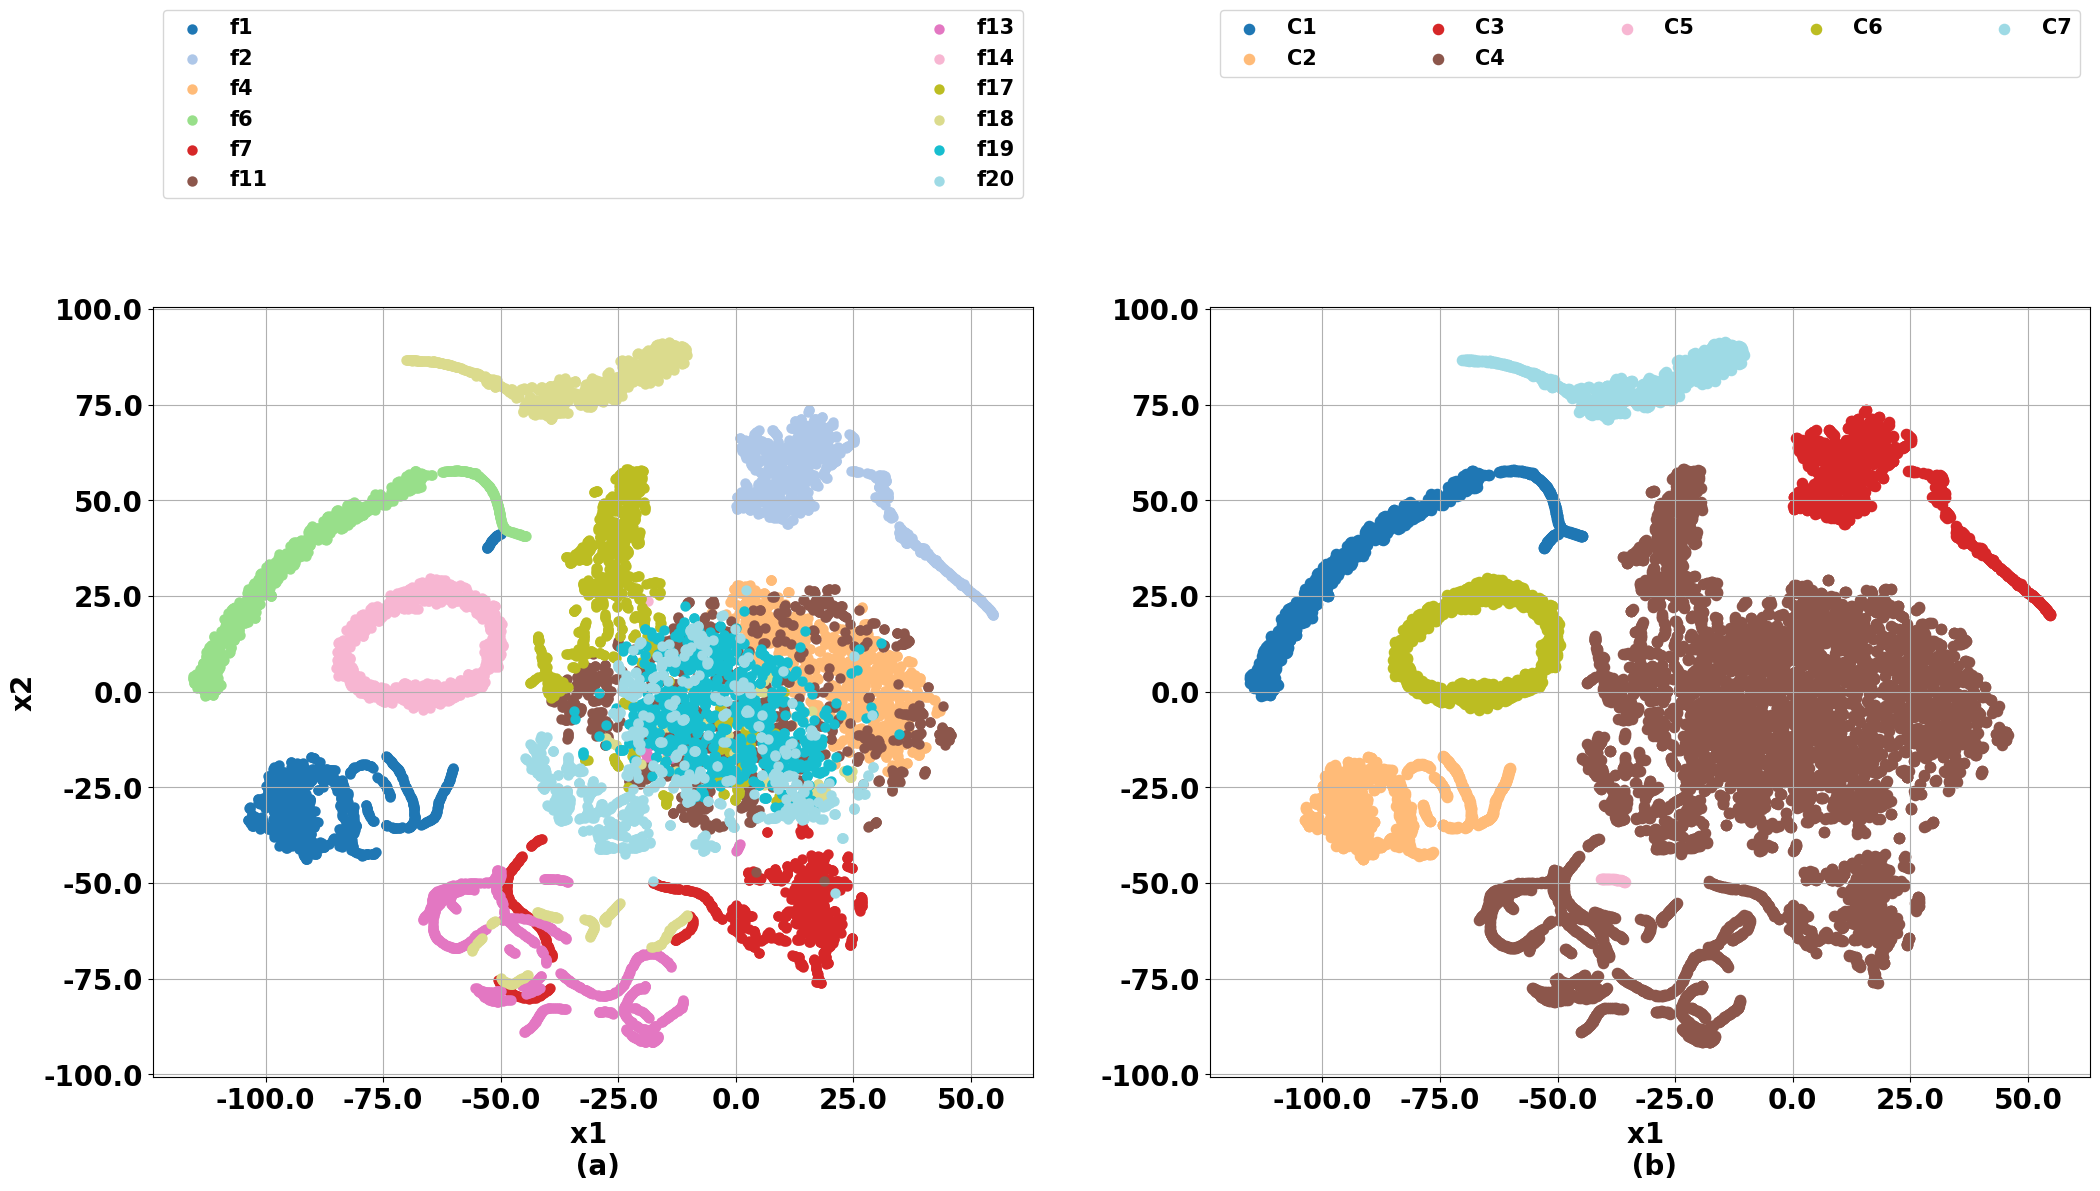

In [ ]:
#lat representation


fig = plt.figure(figsize=(25,10))
gs=gridspec.GridSpec(1,2)


ylabels_fd={'weight':'bold', 'size':20, 'family':'sans-serif'}
ticks_fd={'weight':'bold', 'size':12, 'family':'sans-serif'}
xlabels_fd={'weight':'bold', 'size':20, 'family':'sans-serif'}
title_fd={'weight':'bold','size':20,'family':'sans-serif'}
leg_fd={'weight':'bold','size':15,'family':'sans-serif'}




colors=plt.cm.get_cmap('tab20',num_faults)

ax=plt.subplot(gs[0])

for i,f_type in enumerate(faults_2clus):

    ith_fault_idx=f2c_type==(f_type)
    ax.scatter(X_tsne_lat[ith_fault_idx,0],X_tsne_lat[ith_fault_idx,1],label='f'+str(f_type),c=colors(f_type),s=30,linewidths=2)

ax.legend(loc='upper center', bbox_to_anchor=(0.0, 0.4,1,1),ncol=2,mode='expand',prop=leg_fd)
ax.set_yticklabels(ax.get_yticks(),fontdict=ylabels_fd)
ax.set_xticklabels(ax.get_yticks(),fontdict=xlabels_fd)
ax.set_xlabel('x1 \n (a)',fontdict=xlabels_fd)
ax.set_ylabel('x2',fontdict=xlabels_fd)
ax.grid()


#get the DBSCAN prediction
C=x_dbscan_lat.fit_predict(X_tsne_lat)
clusters=np.unique(x_dbscan_lat.labels_)
num_clusters=len(clusters)
colors=plt.cm.get_cmap('tab20',num_clusters)

#plot the t-SNE data using the DBSCAN clusters assignments for grouping this time
ax=plt.subplot(gs[1])

for i,cluster in enumerate(clusters):
    ith_cluster_idx=C==cluster
    ax.scatter(X_tsne_lat[ith_cluster_idx,0],X_tsne_lat[ith_cluster_idx,1],label='C'+str(i+1),c=colors(i),s=40,linewidths=2)

ax.legend(loc='upper center', bbox_to_anchor=(0.0, 0.4,1,1),ncol=5,mode='expand',prop=leg_fd)

ax.set_yticklabels(ax.get_yticks(),fontdict=ylabels_fd)
ax.set_xticklabels(ax.get_yticks(),fontdict=xlabels_fd)
ax.set_xlabel('x1 \n (b)',fontdict=xlabels_fd)
ax.grid()
#ax.set_ylabel('x2',fontdict=xlabels_fd)
plt.show()

/tmp/ipykernel_97995/388782480.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors=plt.cm.get_cmap('tab20',num_faults)
/tmp/ipykernel_97995/388782480.py:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X_tsne_dev[ith_fault_idx,0],X_tsne_dev[ith_fault_idx,1],label='f'+str(f_type),c=colors(f_type),s=30,linewidths=2)
/tmp/ipykernel_97995/388782480.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),fontdict=ylabels_fd)
/tmp/ipykernel_97995/388782480.py:

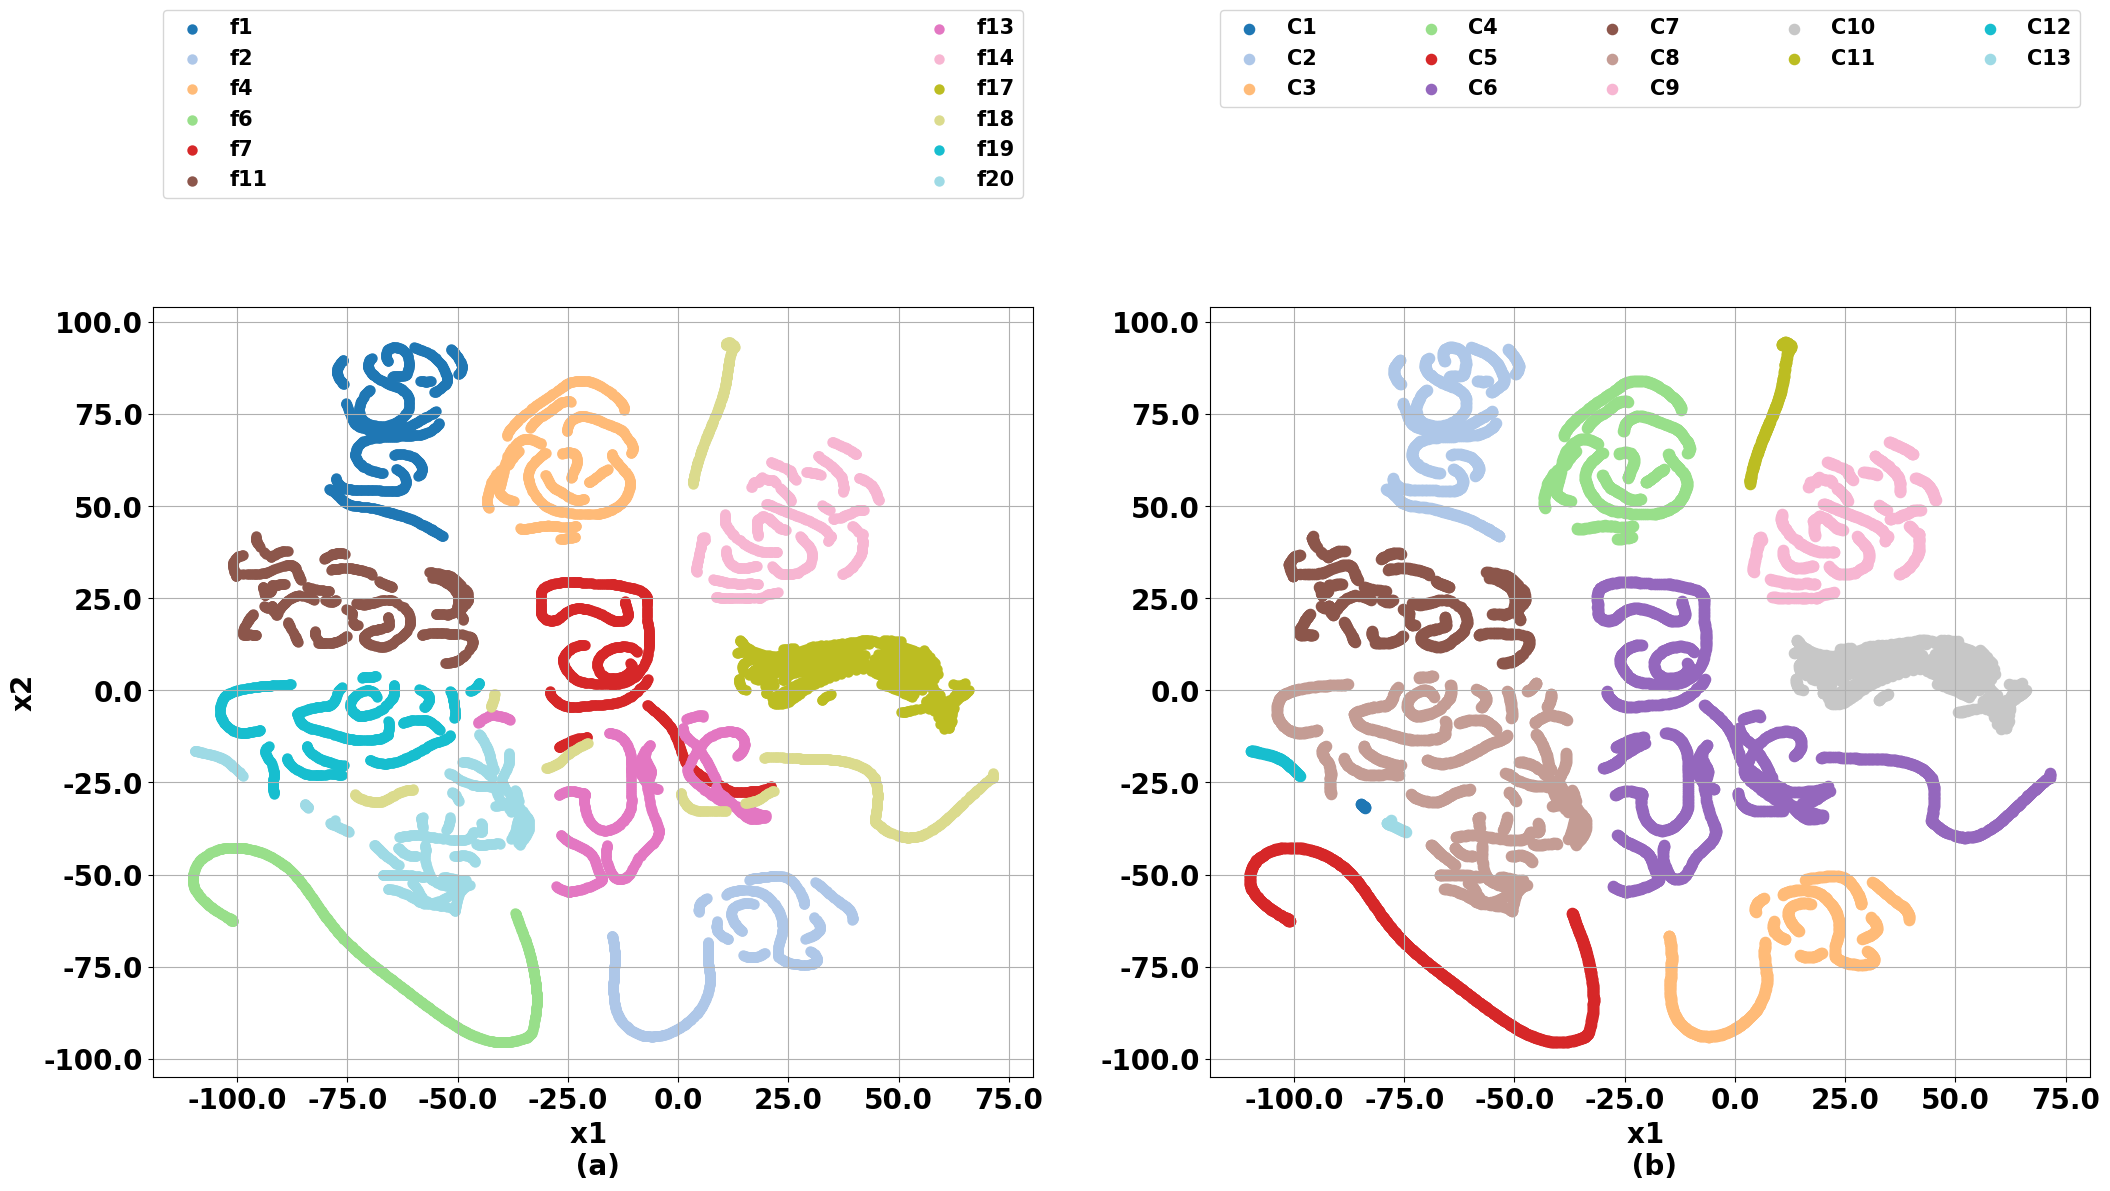

In [ ]:
#deviation info (static residual)


fig = plt.figure(figsize=(25,10))
gs=gridspec.GridSpec(1,2)


ylabels_fd={'weight':'bold', 'size':20, 'family':'sans-serif'}
ticks_fd={'weight':'bold', 'size':12, 'family':'sans-serif'}
xlabels_fd={'weight':'bold', 'size':20, 'family':'sans-serif'}
title_fd={'weight':'bold','size':20,'family':'sans-serif'}
leg_fd={'weight':'bold','size':15,'family':'sans-serif'}




colors=plt.cm.get_cmap('tab20',num_faults)

ax=plt.subplot(gs[0])

for i,f_type in enumerate(faults_2clus):

    ith_fault_idx=f2c_type==(f_type)
    ax.scatter(X_tsne_dev[ith_fault_idx,0],X_tsne_dev[ith_fault_idx,1],label='f'+str(f_type),c=colors(f_type),s=30,linewidths=2)

ax.legend(loc='upper center', bbox_to_anchor=(0.0, 0.4,1,1),ncol=2,mode='expand',prop=leg_fd)
ax.set_yticklabels(ax.get_yticks(),fontdict=ylabels_fd)
ax.set_xticklabels(ax.get_yticks(),fontdict=xlabels_fd)
ax.set_xlabel('x1 \n (a)',fontdict=xlabels_fd)
ax.set_ylabel('x2',fontdict=xlabels_fd)
ax.grid()



#get the DBSCAN prediction
C=x_dbscan_dev.fit_predict(X_tsne_dev)
clusters=np.unique(x_dbscan_dev.labels_)
num_clusters=len(clusters)
colors=plt.cm.get_cmap('tab20',num_clusters)

#plot the t-SNE data using the DBSCAN clusters assignments for grouping this time
ax=plt.subplot(gs[1])

for i,cluster in enumerate(clusters):
    ith_cluster_idx=C==cluster
    ax.scatter(X_tsne_dev[ith_cluster_idx,0],X_tsne_dev[ith_cluster_idx,1],label='C'+str(i+1),c=colors(i),s=40,linewidths=2)

ax.legend(loc='upper center', bbox_to_anchor=(0.0, 0.4,1,1),ncol=5,mode='expand',prop=leg_fd)

ax.set_yticklabels(ax.get_yticks(),fontdict=ylabels_fd)
ax.set_xticklabels(ax.get_yticks(),fontdict=xlabels_fd)
ax.set_xlabel('x1 \n (b)',fontdict=xlabels_fd)
ax.grid()
#ax.set_ylabel('x2',fontdict=xlabels_fd)
plt.show()

/tmp/ipykernel_97995/3126951653.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors=plt.cm.get_cmap('tab20',num_faults)
/tmp/ipykernel_97995/3126951653.py:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X_tsne_temp_res[ith_fault_idx,0],X_tsne_temp_res[ith_fault_idx,1],label='f'+str(f_type),c=colors(f_type),s=30,linewidths=2)
/tmp/ipykernel_97995/3126951653.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),fontdict=ylabels_fd)
/tmp/ipykernel_97995/

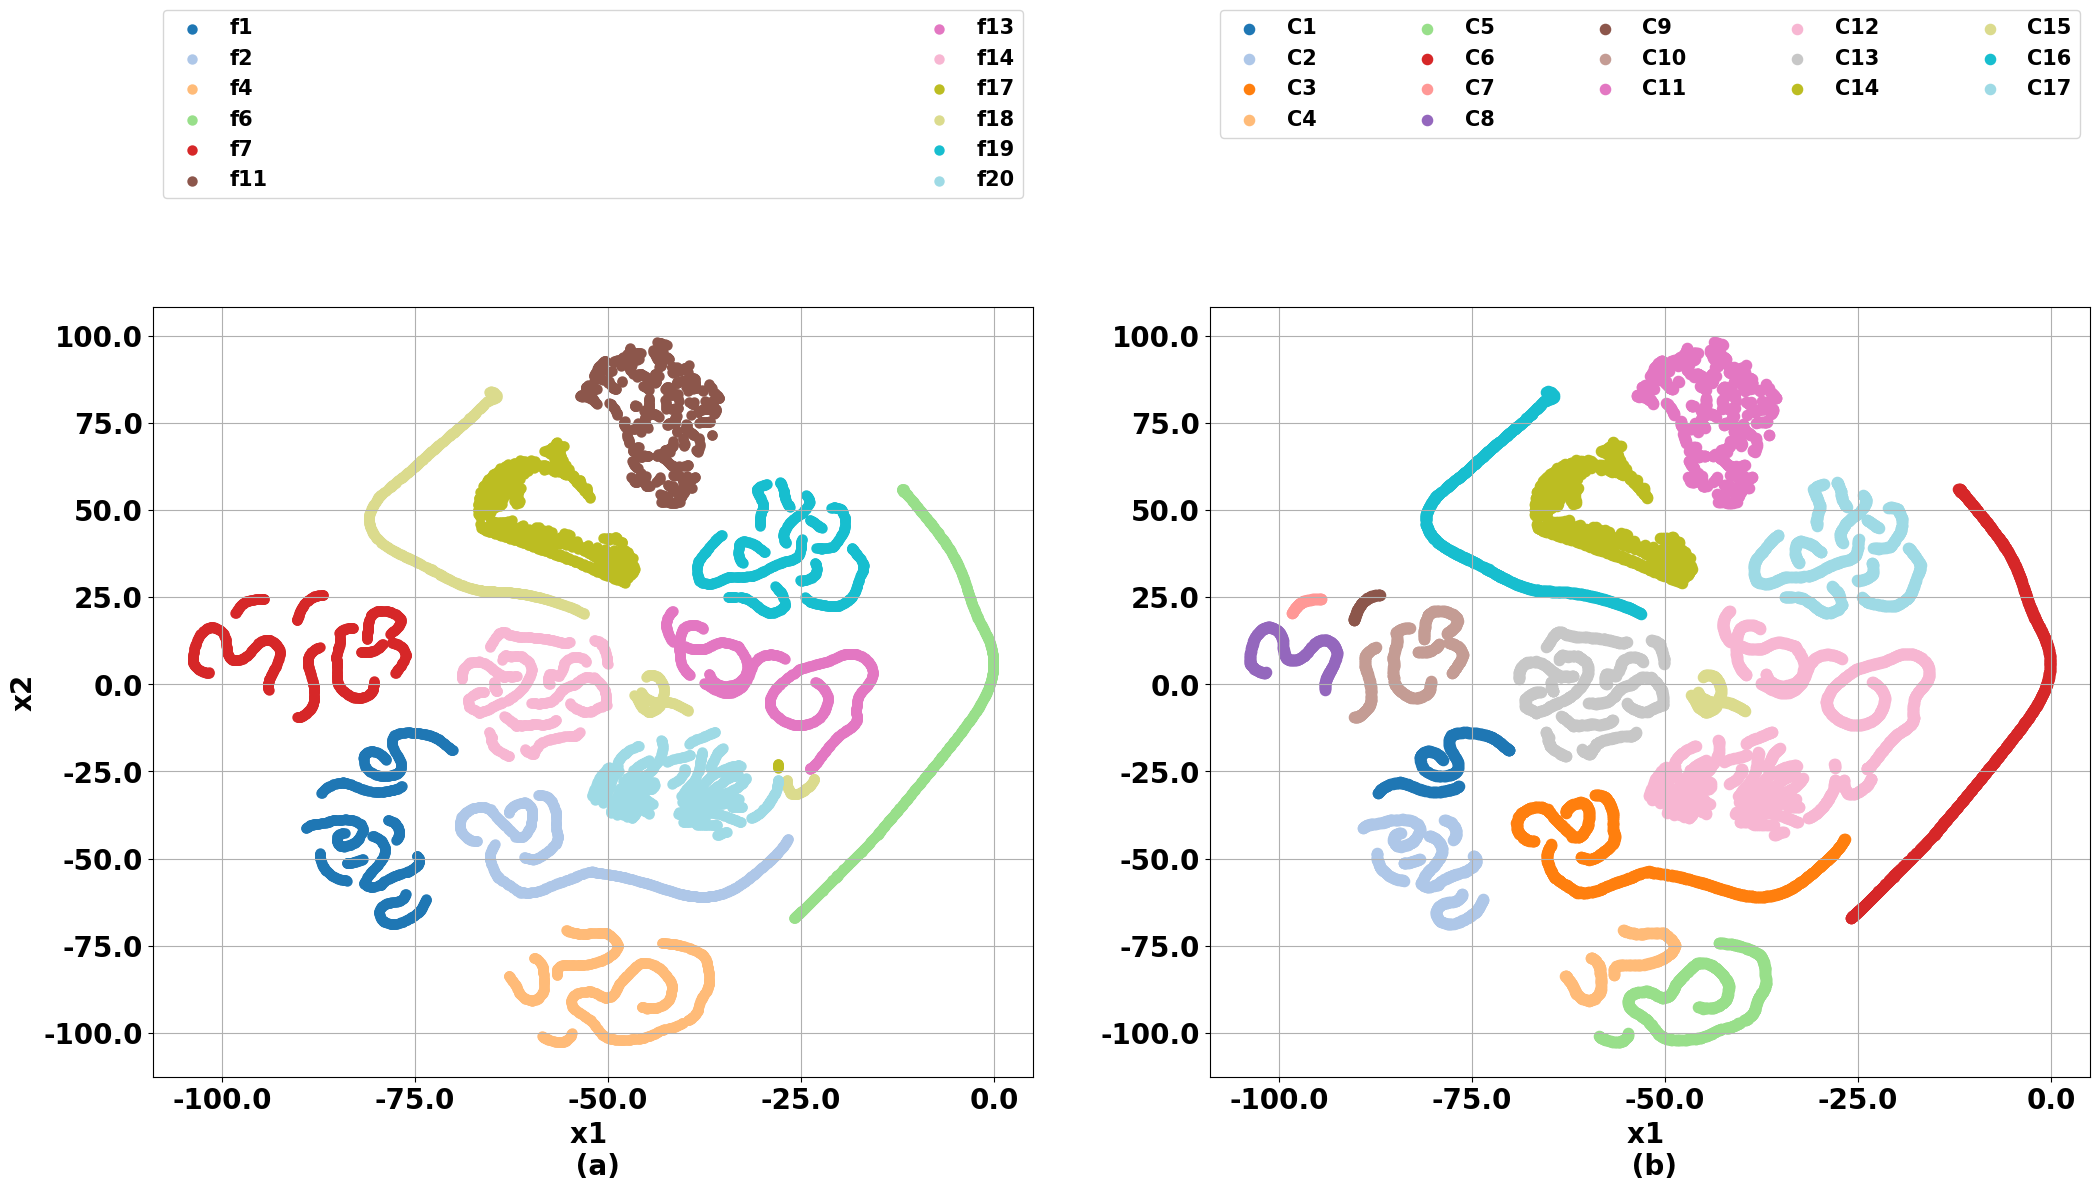

In [ ]:
#temporal residual


fig = plt.figure(figsize=(25,10))
gs=gridspec.GridSpec(1,2)


ylabels_fd={'weight':'bold', 'size':20, 'family':'sans-serif'}
ticks_fd={'weight':'bold', 'size':12, 'family':'sans-serif'}
xlabels_fd={'weight':'bold', 'size':20, 'family':'sans-serif'}
title_fd={'weight':'bold','size':20,'family':'sans-serif'}
leg_fd={'weight':'bold','size':15,'family':'sans-serif'}




colors=plt.cm.get_cmap('tab20',num_faults)

ax=plt.subplot(gs[0])

for i,f_type in enumerate(faults_2clus):

    ith_fault_idx=f2c_type==(f_type)
    ax.scatter(X_tsne_temp_res[ith_fault_idx,0],X_tsne_temp_res[ith_fault_idx,1],label='f'+str(f_type),c=colors(f_type),s=30,linewidths=2)

ax.legend(loc='upper center', bbox_to_anchor=(0.0, 0.4,1,1),ncol=2,mode='expand',prop=leg_fd)
ax.set_yticklabels(ax.get_yticks(),fontdict=ylabels_fd)
ax.set_xticklabels(ax.get_yticks(),fontdict=xlabels_fd)
ax.set_xlabel('x1 \n (a)',fontdict=xlabels_fd)
ax.set_ylabel('x2',fontdict=xlabels_fd)
ax.grid()


#get the DBSCAN prediction
C=x_dbscan_temp_res.fit_predict(X_tsne_temp_res)
clusters=np.unique(x_dbscan_temp_res.labels_)
num_clusters=len(clusters)
colors=plt.cm.get_cmap('tab20',num_clusters)

#plot the t-SNE data using the DBSCAN clusters assignments for grouping this time
ax=plt.subplot(gs[1])

for i,cluster in enumerate(clusters):
    ith_cluster_idx=C==cluster
    ax.scatter(X_tsne_temp_res[ith_cluster_idx,0],X_tsne_temp_res[ith_cluster_idx,1],label='C'+str(i+1),c=colors(i),s=40,linewidths=2)

ax.legend(loc='upper center', bbox_to_anchor=(0.0, 0.4,1,1),ncol=5,mode='expand',prop=leg_fd)

ax.set_yticklabels(ax.get_yticks(),fontdict=ylabels_fd)
ax.set_xticklabels(ax.get_yticks(),fontdict=xlabels_fd)
ax.set_xlabel('x1 \n (b)',fontdict=xlabels_fd)
ax.grid()
#ax.set_ylabel('x2',fontdict=xlabels_fd)
plt.show()

/tmp/ipykernel_97995/3714000957.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors=plt.cm.get_cmap('tab20',num_faults)
/tmp/ipykernel_97995/3714000957.py:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X_tsne_temp_res_zsc[ith_fault_idx,0],X_tsne_temp_res_zsc[ith_fault_idx,1],label='f'+str(f_type),c=colors(f_type),s=30,linewidths=2)
/tmp/ipykernel_97995/3714000957.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),fontdict=ylabels_fd)
/tmp/ipykerne

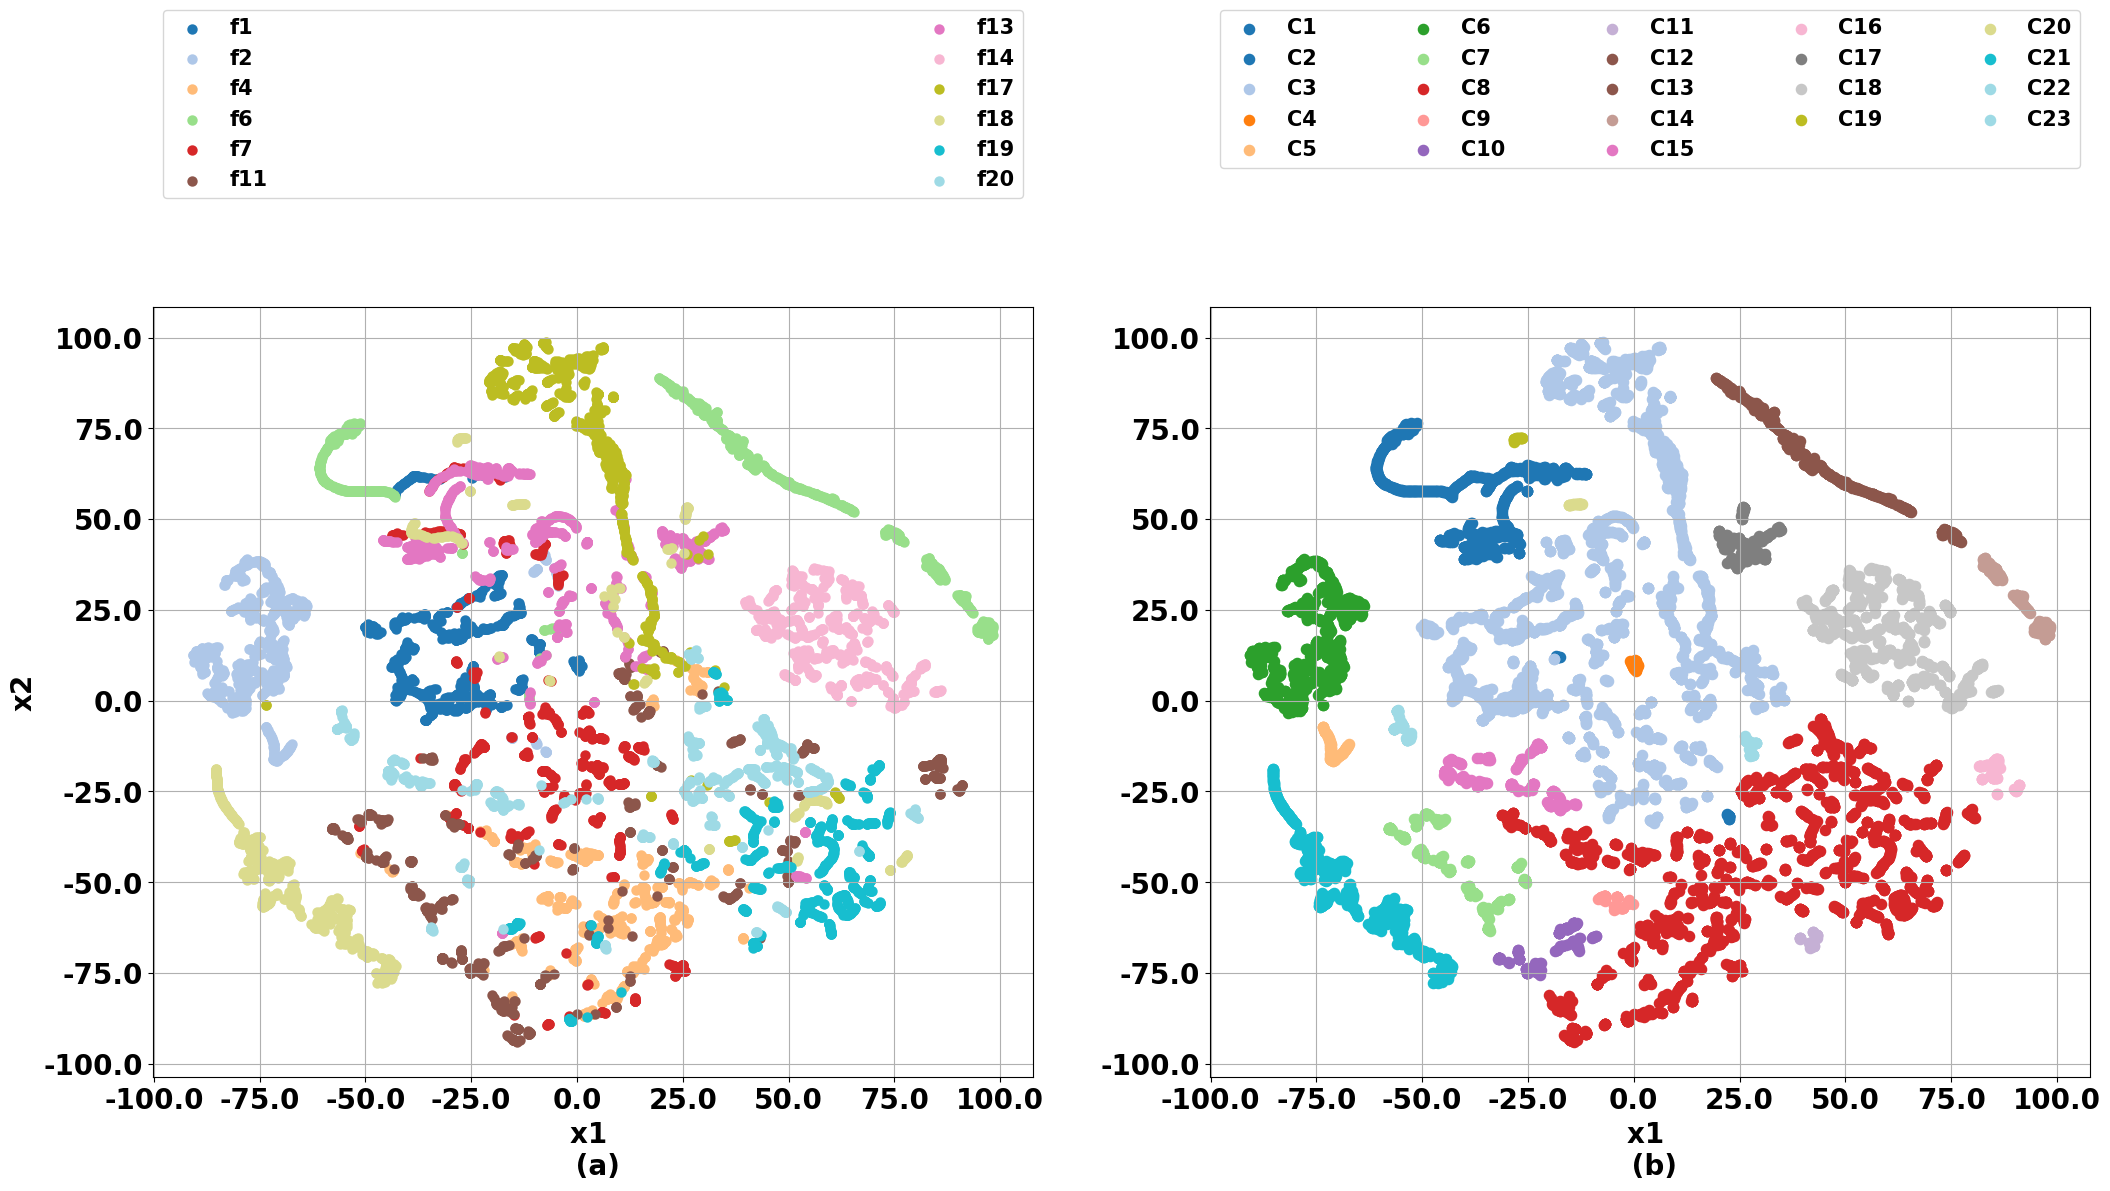

In [ ]:
#temporal residual z-score
faults_2clus=[1,2,4,6,7,11,13,14,17,18,19,20]

fig = plt.figure(figsize=(25,10))
gs=gridspec.GridSpec(1,2)


ylabels_fd={'weight':'bold', 'size':20, 'family':'sans-serif'}
ticks_fd={'weight':'bold', 'size':12, 'family':'sans-serif'}
xlabels_fd={'weight':'bold', 'size':20, 'family':'sans-serif'}
title_fd={'weight':'bold','size':20,'family':'sans-serif'}
leg_fd={'weight':'bold','size':15,'family':'sans-serif'}




colors=plt.cm.get_cmap('tab20',num_faults)

ax=plt.subplot(gs[0])

for i,f_type in enumerate(faults_2clus):

    ith_fault_idx=f2c_type==(f_type)
    ax.scatter(X_tsne_temp_res_zsc[ith_fault_idx,0],X_tsne_temp_res_zsc[ith_fault_idx,1],label='f'+str(f_type),c=colors(f_type),s=30,linewidths=2)

ax.legend(loc='upper center', bbox_to_anchor=(0.0, 0.4,1,1),ncol=2,mode='expand',prop=leg_fd)
ax.set_yticklabels(ax.get_yticks(),fontdict=ylabels_fd)
ax.set_xticklabels(ax.get_yticks(),fontdict=xlabels_fd)
ax.set_xlabel('x1 \n (a)',fontdict=xlabels_fd)
ax.set_ylabel('x2',fontdict=xlabels_fd)
ax.grid()


#get the DBSCAN prediction
C=x_dbscan_temp_res_zsc.fit_predict(X_tsne_temp_res_zsc)
clusters=np.unique(x_dbscan_temp_res_zsc.labels_)
num_clusters=len(clusters)
colors=plt.cm.get_cmap('tab20',num_clusters)

#plot the t-SNE data using the DBSCAN clusters assignments for grouping this time
ax=plt.subplot(gs[1])

for i,cluster in enumerate(clusters):
    ith_cluster_idx=C==cluster
    ax.scatter(X_tsne_temp_res_zsc[ith_cluster_idx,0],X_tsne_temp_res_zsc[ith_cluster_idx,1],label='C'+str(i+1),c=colors(i),s=40,linewidths=2)

ax.legend(loc='upper center', bbox_to_anchor=(0.0, 0.4,1,1),ncol=5,mode='expand',prop=leg_fd)

ax.set_yticklabels(ax.get_yticks(),fontdict=ylabels_fd)
ax.set_xticklabels(ax.get_yticks(),fontdict=xlabels_fd)
ax.set_xlabel('x1 \n (b)',fontdict=xlabels_fd)
ax.grid()
#ax.set_ylabel('x2',fontdict=xlabels_fd)
plt.show()

<font size=5 color=red> The residual z-score data do not perform well in spearating the faults </font>


<font size=6 color=teal> Pesudo confusion matrix </font>
<font size=5> It is based on the static residual data (for now) </font>


In [ ]:
l_all=[]
num_clusters=len(np.unique(x_dbscan_dev.labels_))
for f_type in np.unique(f2c_type):
    l=np.zeros(shape=[1,num_clusters])
    idx=f_type==f2c_type
    fault_samples_clus_ass= x_dbscan_dev.labels_[idx]

    corres_unique_labels=np.unique(fault_samples_clus_ass)

    for j in corres_unique_labels:
        l[0,j]=np.sum(fault_samples_clus_ass==j)

    l_all.append(l)




In [ ]:
np.unique(x_dbscan_dev.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

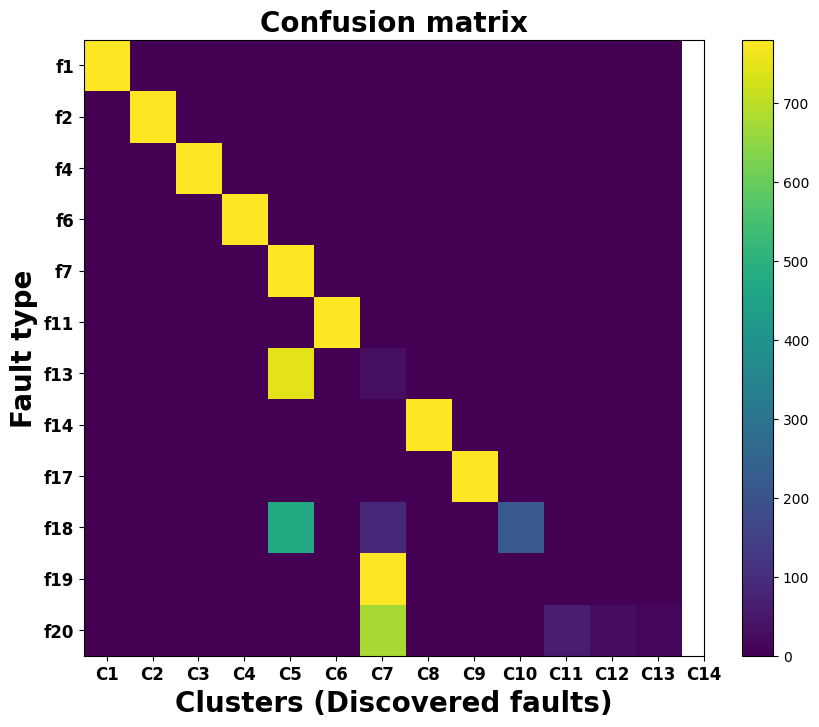

C0     C1     C2     C3     C4     C5     C6     C7     C8     C9  \
f1   780.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
f2     0.0  780.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
f4     0.0    0.0  780.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
f6     0.0    0.0    0.0  780.0    0.0    0.0    0.0    0.0    0.0    0.0   
f7     0.0    0.0    0.0    0.0  780.0    0.0    0.0    0.0    0.0    0.0   
f11    0.0    0.0    0.0    0.0    0.0  780.0    0.0    0.0    0.0    0.0   
f13    0.0    0.0    0.0    0.0  747.0    0.0   33.0    0.0    0.0    0.0   
f14    0.0    0.0    0.0    0.0    0.0    0.0    0.0  780.0    0.0    0.0   
f17    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  780.0    0.0   
f18    0.0    0.0    0.0    0.0  475.0    0.0   88.0    0.0    0.0  217.0   
f19    0.0    0.0    0.0    0.0    0.0    0.0  780.0    0.0    0.0    0.0   
f20    0.0    0.0    0.0    0.0    0.0    0.0  677.0    0.0    0.0    0.0   

      C10   C11   C12  
f1    0.0   0.0   0.0  
f2    0.0   0.0   0.0  
f4    0.0   0.0   0.0  
f6    0.0   0.0   0.0  
f7    0.0   0.0   0.0  
f11   0.0   0.0   0.0  
f13   0.0   0.0   0.0  
f14   0.0   0.0   0.0  
f17   0.0   0.0   0.0  
f18   0.0   0.0   0.0  
f19   0.0   0.0   0.0  
f20  63.0  27.0  13.0

In [ ]:
tab_columns=["C"+str(i) for i in (np.unique(x_dbscan_dev.labels_)+1)]
tab_index=["f"+str(i) for i in np.unique(f2c_type)]

data=np.concatenate(l_all,axis=0)


# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Display the heatmap using plt.imshow()
heatmap = ax.imshow(data, cmap='viridis', aspect='auto')

# Add a color bar
cbar = plt.colorbar(heatmap, ax=ax)

# Customize the heatmap
ax.set_title('Confusion matrix',fontdict=title_fd)
ax.set_xlabel('Clusters (Discovered faults)',fontdict=xlabels_fd)
ax.set_ylabel('Fault type',fontdict=xlabels_fd)

xticks_labels = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']
ax.set_xticks(np.arange(len(xticks_labels)))
ax.set_xticklabels(xticks_labels,fontdict=ticks_fd)

ytick_labels=['f'+str(i) for i in np.unique(f2c_type)]
ax.set_yticks(np.arange(len(ytick_labels)))
ax.set_yticklabels(ytick_labels,fontdict=ticks_fd)

# Display the heatmap
plt.show()

conf_mat=pd.DataFrame(np.concatenate(l_all,axis=0),columns=tab_columns,index=tab_index)
conf_mat

In [ ]:
red_fault_types=np.unique(f2c_type)
purity=[]
eff=[]
Q=[]
for column in conf_mat.columns:
    jth_cluster=conf_mat[column]
    N_ij=np.max(jth_cluster)
    fault_idx=np.argmax(jth_cluster)
    fault_id=red_fault_types[fault_idx]
    #print(fault_id)
    N_j=np.sum(jth_cluster)
    p=N_ij/N_j*100
    purity.append(p)
    e=(N_ij/780*100)
    eff.append(e)

    Q.append(0.7*p+.3*e)

print(tab_columns)
print(purity)
print(eff)
print(Q)

['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12']
[100.0, 100.0, 100.0, 100.0, 38.961038961038966, 100.0, 49.42965779467681, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 27.82051282051282, 8.076923076923077, 3.4615384615384617, 1.6666666666666667]
[100.0, 100.0, 100.0, 100.0, 57.27272727272727, 100.0, 64.60076045627376, 100.0, 100.0, 78.34615384615384, 72.42307692307692, 71.03846153846153, 70.5]


<font size=6 color=teal> Inspecting the model prediction under faults (discussion) </font>


14


2024-07-21 22:55:52.919120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2024-07-21 22:55:52.919539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
/home/melbelta/PycharmProjects/IFDC-brnn/IFD/losses/variational/LossesAndMetrics.py:187: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_k.set_yticklabels(ax_k.get_yticks(),fontdict=ylabels_fd)
/home/melbelta/PycharmProjects/IFDC-brnn/IFD/losses/variational/LossesAndMetrics.py:203: UserWarning: FixedFormatter s

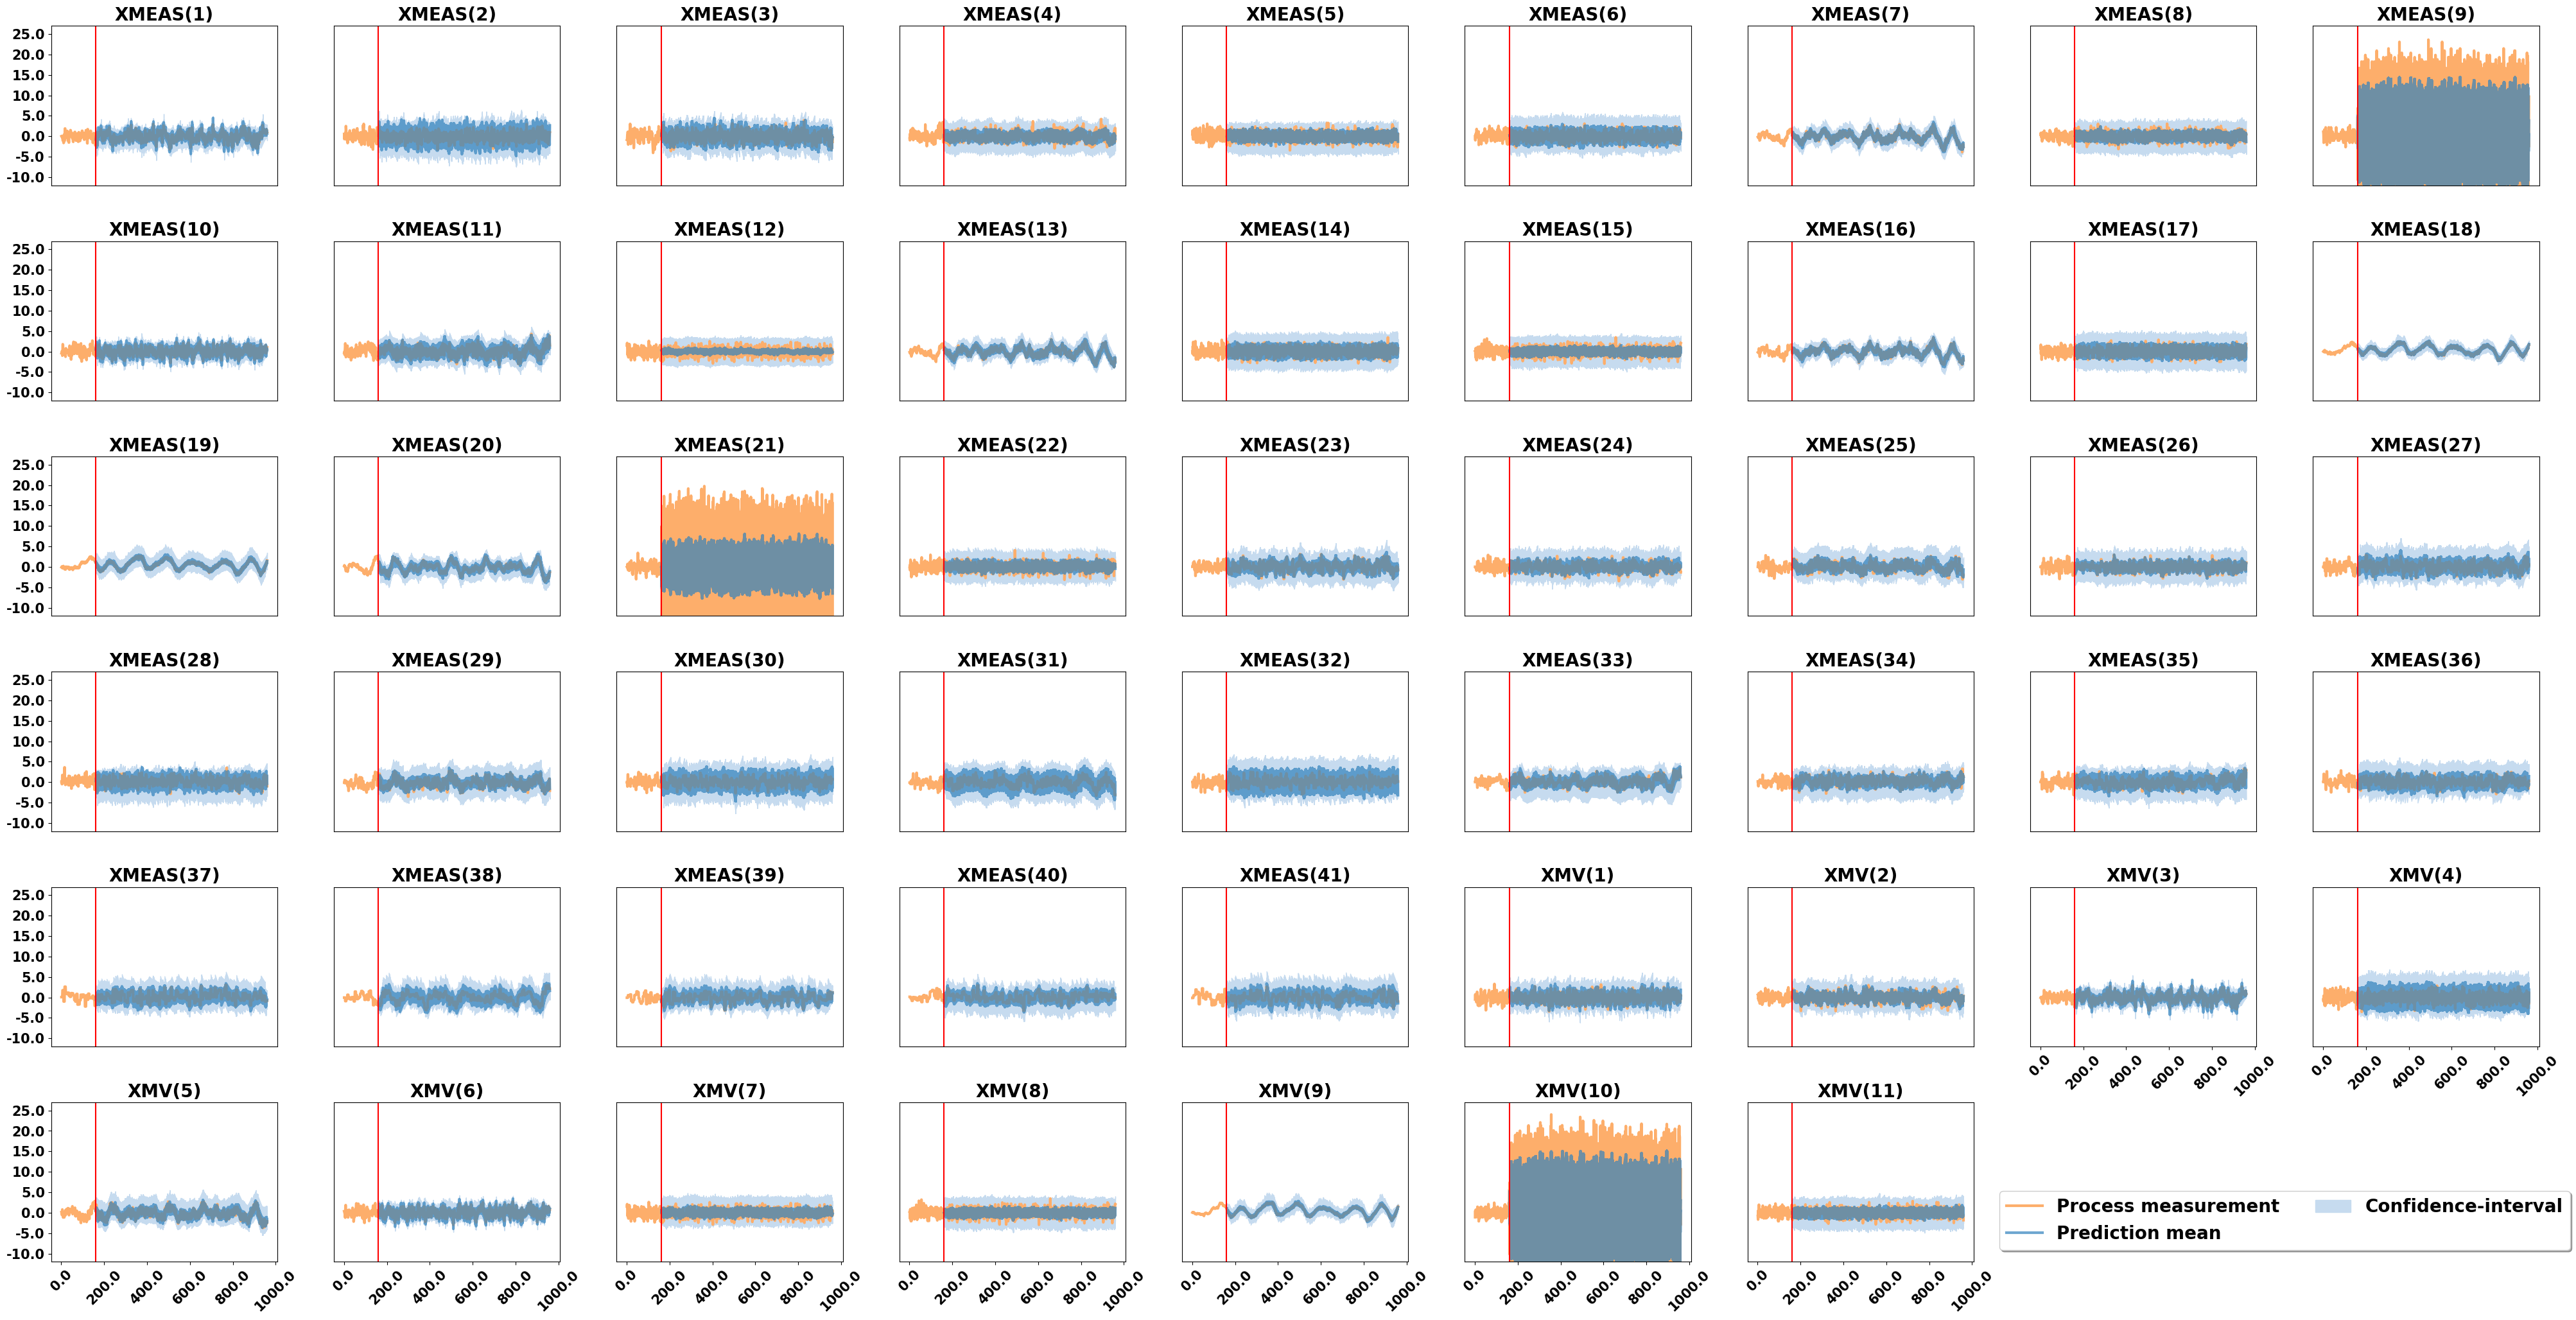

In [ ]:
#in this notebook (faulty_as_dataset_l) contains the NOC data at the first index
fault_type=14#faults_2clus[2]
print(fault_type)
wrapper_model=lambda x: ss_mdl(x)[0]

full_target_seq_fi=fault_tep_data[fault_type-1].to_numpy()[:,slice(1,-1)]

_=lossmod.visualize_model_results(dataset=faulty_as_dataset_l[fault_type],full_target_seq=full_target_seq_fi,mdl=wrapper_model,conf_width=3,process_vars_name=columns,fault_injection_sample=160,ylims=[-12,27],mean_plot_alpha=0.7,uncertainty_bound_alpha=1)

/tmp/ipykernel_97995/1315434883.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  new_ax.set_xticklabels(ticks_ax.get_xticks(),fontdict=xlabels_fd)


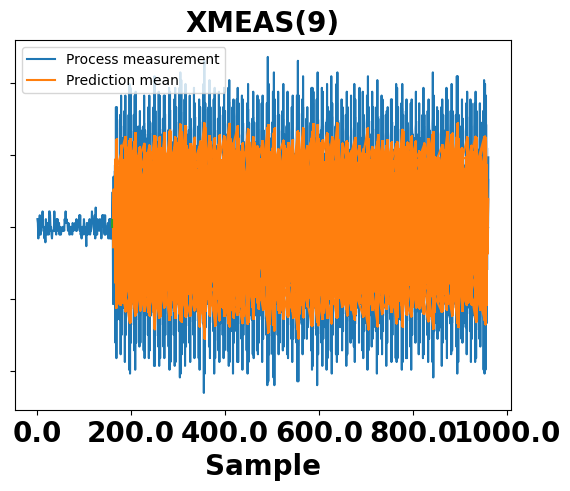

In [ ]:
var_id=9
selected_ax=_[var_id-1]
ticks_ax=_[-1]
# Step 3: Create a new figure and axis
new_fig, new_ax = plt.subplots()

# Step 4: Copy the content from the selected subplot to the new axis
# Copy lines
for line in selected_ax.get_lines():
    new_ax.plot(line.get_xdata(), line.get_ydata(), label=line.get_label())

# Copy filled regions
for collection in selected_ax.collections:
   # if isinstance(collection, plt.PolyCollection):
        # Assume the first path of the collection is the fill_between path
    path = collection.get_paths()[0]
    verts = path.vertices
    new_ax.fill_between(verts[:, 0], verts[:, 1], alpha=collection.get_alpha(), color=collection.get_facecolor()[0])

# Optional: Copy title, labels, and legend if needed


new_ax.set_title(selected_ax.get_title(),fontdict=title_fd)
new_ax.set_xticklabels(ticks_ax.get_xticks(),fontdict=xlabels_fd)
new_ax.set_yticklabels(selected_ax.get_yticks(),fontdict=ticks_fd)
new_ax.set_xlabel('Sample',fontdict=xlabels_fd)
new_ax.legend()


<font size=6 color=teal> Inspecting the distribution of the TEP data under different fault types </font>


In [ ]:
def norm_time(data):
    #this function accepts a data of shape [time,features] and returns a (time) normalized verison
    mean=tf.reduce_mean(data,axis=0)
    std=tf.math.reduce_std(data,axis=0)
    return (data-mean)/(std+10**-5)




window_sizes=[10,20,30,40,100,500]


fault_type=1

process_vars=slice(1,-1) #exclude the first and last columns (smapleid, faultNumber)
#step 1 get the noc and fault data
noc_data=noc_ts_norm.to_numpy()[:,process_vars]
fault_data=fault_tep_data[fault_type-1].to_numpy()[:,process_vars]
num_samples=len(fault_data)
#step 2 obtain the instance normalized fault data
#2.1 set the window size
inst_norm_fdata_diff_windows_list=[] #TODO: It might better to replace this with a dictionary
for i,window_size in enumerate(window_sizes):
    in_width=window_size
    out_width=window_size
    shift=1
    stride=window_size
    #2.2 divide the data into windows and apply instance normalization
    fault_ds=DataSetCreator(data=fault_data,in_width=in_width,out_width=out_width,stride=stride,batch_size=num_samples) #setting the batch size to num_samples will create a single batch and facilitate the combination of the windows into a single set
    #the following is to check if the model has been trained
    normalize_instance=lambda i,j: norm_time(i)
    inst_norm_fdata=fault_ds.dataset.map(normalize_instance)
    #2.3 combine the windows into a single set
    inst_norm_fdata=inst_norm_fdata.get_single_element()
    inst_norm_fdata=np.concatenate(inst_norm_fdata,axis=0) #I don't know why the tf.concat does not work similarly
    inst_norm_fdata_diff_windows_list.append(inst_norm_fdata)








In [ ]:
# #plot the variables distribution
# #plot layout setting
# num_vars=noc_data.shape[-1]
# num_cols=7
# num_rows=ceil(num_vars/num_cols)
# #figure and gridspec
# fig=plt.figure(figsize=(30,30))
# gs=g_spec=gridspec.GridSpec(num_rows,num_cols)
# #plot colors
# cmap=plt.get_cmap('viridis')
# n=len(window_sizes)
# colors=np.linspace(0, 1, n)
# #plotting loop
# var_id=0
#
# for i in range(num_rows):
#     for j in range(num_cols):
#
#         if var_id+1<=num_vars:
#             ax=plt.subplot(gs[i,j])
#
#             #get the variable distribution under NOC
#             var_noc=noc_data[:,var_id]
#             pdf_estimator=kde(var_noc)
#             var_range=np.linspace(min(var_noc),max(var_noc),100)
#             noc_pdf=pdf_estimator(var_range)
#
#             ax.plot(var_range,noc_pdf,color='tab:blue',mew=4,label='noc')
#             ax.fill_between(var_range,noc_pdf,color='tab:blue',alpha=0.2)
#             ax.set_title(columns[var_id])
#             #adjust the tick paramters for a clearer figure
#             #ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2f}'.format(y)))
#
#             #get the variable distribution for the  fault data without normalization
#             var_fault=fault_data[:,var_id] #TODO: I might want to add a pdb trace at this line to make sure that the slicing is correct
#             pdf_estimator=kde(var_fault)
#             var_range=np.linspace(min(var_fault),max(var_fault),100)
#             fault_i_pdf=pdf_estimator(var_range)
#             #plot the pdfs of the fault
#             ax.plot(var_range,fault_i_pdf,color='tab:orange',mew=4,label='f'+str(fault_type))
#             ax.fill_between(var_range,fault_i_pdf,color='tab:orange',alpha=0.2)
#
#             #get the variable distribution for the  fault data with normalization of different window size
#             for k,norm_fdata_window in enumerate(inst_norm_fdata_diff_windows_list):
#                 var_fault_norm_window_k=norm_fdata_window[:,var_id] #TODO: I might want to add a pdb trace at this line to make sure that the slicing is correct
#                 #print(var_id,k)
#                 pdf_estimator=kde(var_fault_norm_window_k)
#                 var_range=np.linspace(min(var_fault_norm_window_k),max(var_fault_norm_window_k),100)
#                 fault_i_pdf=pdf_estimator(var_range)
#                 #plot the pdfs of the fault
#                 ax.plot(var_range,fault_i_pdf,color=cmap(colors[k]),mew=4,label='f'+str(fault_type)+'-norm-T:'+str(window_sizes[k]))
#                 ax.fill_between(var_range,fault_i_pdf,color=cmap(colors[k]),alpha=0.2)
#
#
#             y_ticks=ax.get_yticks()
#             y_tick_labels = ['{:.2f}'.format(y) for y in y_ticks]
#             ax.set_yticklabels(y_tick_labels,fontsize=10,weight='bold')
#             ax.set_xticklabels(ax.get_xticks(),fontsize=10,weight='bold')
#
#             if i == 0 and j == num_cols - 1:
#                         ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
#
#             var_id+=1

<font size=6 color=teal> Principal Component Analysis </font>
<font size=5> Steps: </font>:
1. Get the i-th cluster data
2. Perform PCA
3. Compute the cumulative sum of percentage of the expalined variance as more PCs are used
4. Determine the number of PCs reqires to explain more than 80% of the variance (<font color=teal> setting this number was based on intuition</font>)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
class FaultLocRule():


    def __init__(self,data,fault_type : int, feature_names,var_thresh):

        if fault_type is not None:
            self.name='localization rule: f('+str(fault_type)+')'
        else:
            self.name='localization rule'

        self.feature_names=feature_names

        self.data=data

        self.var_thresh=var_thresh #var_thresh is in %percentage
        self.pca=PCA()
        self.num_pca=None
        self.ex_var_perc=None
        self.cs_ex_var=None

        self._zero_neighbourhood=1

    def fit(self):
        self.pca.fit(self.data)

    def analyze_var(self,ex_var_thresh):
        #get the explained variance
        ex_var=self.pca.explained_variance_
        ex_var_perc=ex_var/np.sum(ex_var)*100
        cs_exvar=np.cumsum(ex_var_perc)
        #find how many PCs are needed to achieve var_thresh
        num_pcs=np.where(cs_exvar>=ex_var_thresh)[0][0]+1 #+1 is used since zero-based indexing is used
        self.num_pcs=num_pcs
        self.ex_var_perc=ex_var_perc
        self.cs_ex_var=cs_exvar
        return ex_var_perc,cs_exvar

    def get_max_dev(self,num_top_contrib=5):
        mu_dev=np.mean(self.data,axis=0)
        idx_high=np.flip(np.argsort(mu_dev,axis=0))
        idx_bias=np.argwhere(np.abs(mu_dev)>=self._zero_neighbourhood)
        bool_idx=[True if idx_h in idx_bias else False for idx_h in idx_high] #TODO: I have to check this again
        idx=idx_high[bool_idx]
        return [self.feature_names[index] for index in idx[:num_top_contrib]]

    # def get_pc_top_contrib(self): #TODO: Consider removing this commented part as I changed the determination of the top contributors
    #     l=[]
    #     for i in range(self.num_pcs):
    #         features_contrib=self.pca.components_[i] #this is the unsorted contribution
    #         #sort the features in descending order
    #         idx_fc_descend=np.flip(np.argsort(np.abs(features_contrib,)),axis=0) #use the absolute value in the sorting process
    #
    #         sorted_fc=features_contrib[idx_fc_descend] #this is the sorted features based on the contribution score
    #         sorted_fc_abs=np.abs(sorted_fc)
    #         fc_perc=sorted_fc_abs/np.sum(sorted_fc_abs)*100
    #         sorted_feature_names=[self.feature_names[i] for i in idx_fc_descend]
    #         temp_df=pd.DataFrame([sorted_feature_names,sorted_fc,fc_perc]).T
    #         temp_df.columns=['var_name','contrib','contrib_perc']
    #
    #         l.append(temp_df)
    #     return l
    #
    #
    #
    #
    # def analyze_top_contributor(self,num_pcs,num_top_contrib=10):
    #     pc_contrib_info=self.get_pc_top_contrib()
    #
    #     if num_pcs is not None:
    #         pass
    #     else:
    #         num_pcs=self.num_pcs
    #
    #     #limit the information to a num_top_contrib variables
    #     red_contrib_info=[]
    #     for df in pc_contrib_info[:num_pcs]:
    #         red_contrib_info.append(df[:num_top_contrib])
    #
    #     #
    #     intersect_set=set(red_contrib_info[0]['var_name'])
    #     for df in red_contrib_info:
    #         #pdb.set_trace()
    #         intersect_set=intersect_set.intersection(set(df['var_name']))
    #
    #     return red_contrib_info, intersect_set

    def analyze_top_contrib_with_weight(self,num_top_contrib=10):

        _,_=self.analyze_var(ex_var_thresh=self.var_thresh)
        weight_pc_sum=0
        for i in range(self.num_pcs):
            weight_pc_sum=weight_pc_sum+self.ex_var_perc[i]*np.abs(self.pca.components_[i])

        idx=np.flip(np.argsort(weight_pc_sum))
        sorted_weight_pc_sum=[weight_pc_sum[i] for i in idx[:num_top_contrib]]
        contributor_names=[self.feature_names[i] for i in idx[:num_top_contrib]]
        # xlabels_fd = {'weight': 'bold', 'size': 10, 'family': 'sans-serif', 'rotation': 45}
        # plt.bar(np.arange(len(sorted_weight_pc_sum)),sorted_weight_pc_sum)
        # ax=plt.gca()
        # #ax.set_xticklabels(contributor_names,fontdict=xlabels_fd)
        return contributor_names, weight_pc_sum




In [ ]:
from skimage.restoration import denoise_tv_chambolle
from scipy.signal import butter,filtfilt


def butter_lowpass_filter(data, cutoff_frequency, order=8):
    """
    Apply a low-pass Butterworth filter to the data.

    Parameters:
    - data: 2d NumPy array representing the input signal [time,features].
    - cutoff_frequency: Cutoff frequency of the filter.
    - sampling_rate: Sampling rate of the signal.
    - order: Order of the filter.

    Returns:
    - Filtered signal.
    """
    data=data.T #transpose so that the variables are at the first axis
    filtered_data=[]
    for var_signal in data:

        #nyquist = 0.5 * sampling_rate
        #normal_cutoff = cutoff_frequency / nyquist
        #print(normal_cutoff)
        b, a = butter(order, cutoff_frequency, btype='low', analog=False)
        filtered_signal = filtfilt(b, a, var_signal)
        filtered_data.append(filtered_signal)
    #pdb.set_trace()
    return np.concatenate([filtered_data],axis=1).T


def filter_tep_timeseries(data,denoising_weight=0.1):
    #data is an array like of size N by K (52 in this study), where N is the number of samples
    # num_vars=data.shape[-1]
    # denoised_data=[]
    #
    # for var in range(num_vars):
    #     var_data=data[:,var]
    denoised=denoise_tv_chambolle(data,weight=denoising_weight)
    return denoised
    #     denoised_data.append(denoised)
    #
    # denoised_data=np.concatenate(denoised_data)
    # return np.reshape(denoised_data,newshape=[-1,num_vars])


<font size=5 color=teal> Butterworth vs TVR filtering </font>

/home/melbelta/PycharmProjects/IFDC-brnn/IFD/losses/variational/LossesAndMetrics.py:316: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_k.set_yticklabels(ax_k.get_yticks(), fontdict=ylabels_fd)
/home/melbelta/PycharmProjects/IFDC-brnn/IFD/losses/variational/LossesAndMetrics.py:328: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_k.set_xticklabels(ax_k.get_xticks(), fontdict=xlabels_fd)


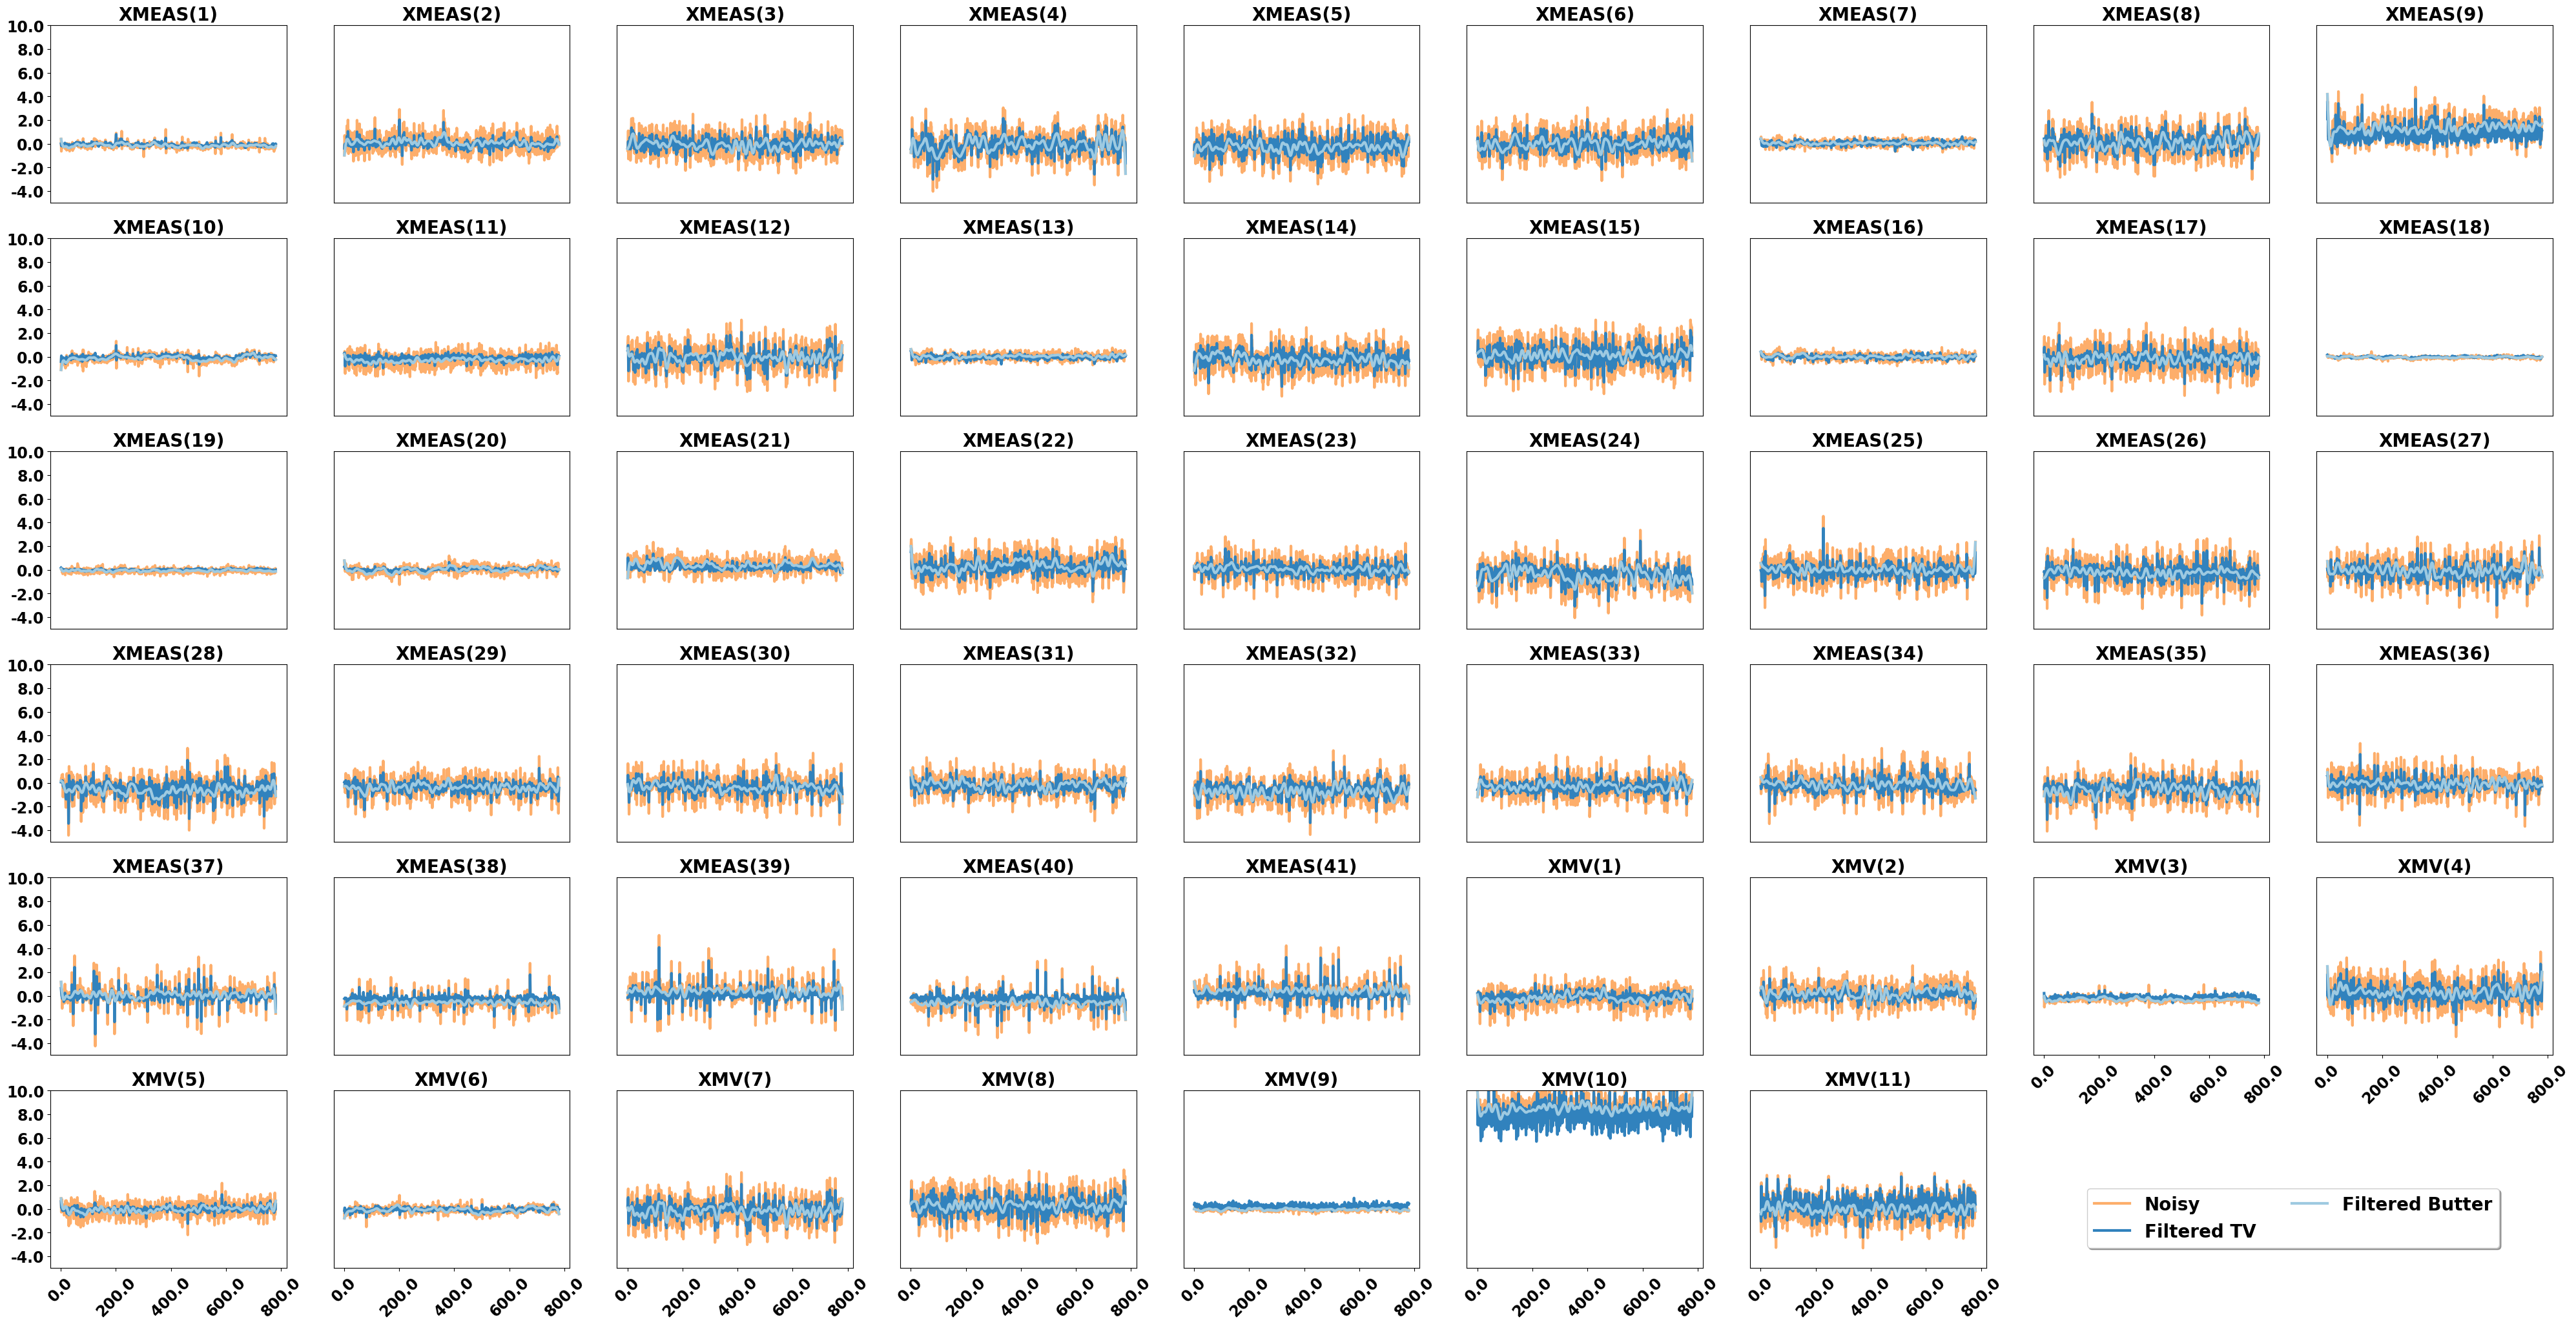

In [ ]:
fault_type=4
pf_ts_cont=[np.reshape(i,newshape=[-1,52]) for i in pf_time_series_no_overlap]
f_data = pf_ts_cont[fault_type]
tv_filtered_f_data = filter_tep_timeseries(f_data,denoising_weight=0.3)
butter_filtered_f_data = butter_lowpass_filter(data=f_data,cutoff_frequency=0.1,order=8)
data_labels=["Noisy" , "Filtered TV", "Filtered Butter"]
data_colors=[6,0,2]
data=[f_data, tv_filtered_f_data, butter_filtered_f_data]
_=lossmod.plot_tep_timeseris(data=data,ylims=[-5,10],fault_injection_sample=None,process_vars_name=columns,data_labels=data_labels,data_colors=data_colors)

<font size=5 color=teal> Applying PCA to temporal residual timeseries data </font>

The fault type under consideration is: f4


/tmp/ipykernel_97995/3319453380.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors=plt.cm.get_cmap('tab20c', 20)
/tmp/ipykernel_97995/3319453380.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),fontdict=ticks_fd)


array([65.66261128, 19.31553794,  4.9113187 ,  3.52721594])

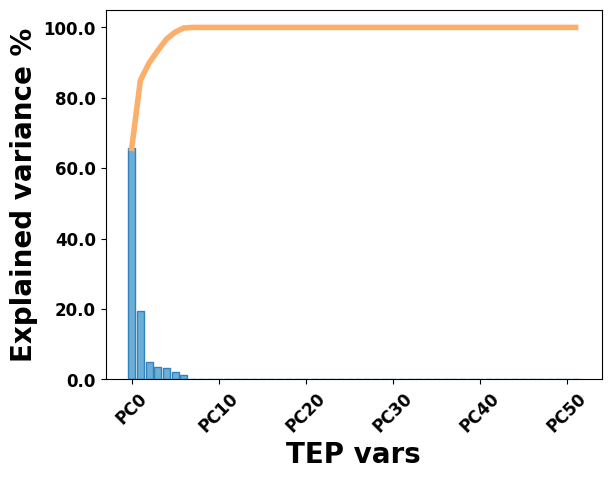

<Figure size 640x480 with 0 Axes>

In [ ]:
#names of the residual features
temp_res_feature_names=[name+'-mu' for name in columns] + [name+'-std' for name in columns]
#name of the process variables
tep_process_var_names=columns



fault_type=4#faults_2clus[1]
print("The fault type under consideration is: f{}".format(fault_type))
#idx_ftype=fault_type_l==fault_type

f_data=np.reshape(pf_time_series_no_overlap[fault_type],newshape=[-1,52]) #I expect that applying a filter to this when overlapping sequences are used will cause problems
f_data=butter_lowpass_filter(data=f_data,cutoff_frequency=0.01)
f1_rule=FaultLocRule(data=f_data,fault_type=1, feature_names=temp_res_feature_names,var_thresh=70)
f1_rule.fit()

#plotting settings
xticks_fd={'weight':'bold', 'size':12, 'family':'sans-serif','rotation':45}
colors=plt.cm.get_cmap('tab20c', 20)
xticks=np.arange(0,52,10)
xtick_labels=['PC'+str(i) for i in xticks]

ex_var_perc,var_cs=f1_rule.analyze_var(70)
plt.bar(np.arange(len(ex_var_perc)),ex_var_perc,facecolor=colors(1),edgecolor=colors(0)) #0,6,3
plt.plot(np.arange(len(ex_var_perc)),var_cs,linewidth=4,color=colors(6))
ax=plt.gca()
ax.set_yticklabels(ax.get_yticks(),fontdict=ticks_fd)
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels,fontdict=xticks_fd)
plt.xlabel('TEP vars',fontdict=xlabels_fd)
plt.ylabel('Explained variance %',fontdict=ylabels_fd)
plt.figure()


ex_var_perc[:4]

['XMV(10)-mu', 'XMEAS(9)-mu']


/tmp/ipykernel_97995/2149885658.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),fontdict=ticks_fd)


<Figure size 640x480 with 0 Axes>

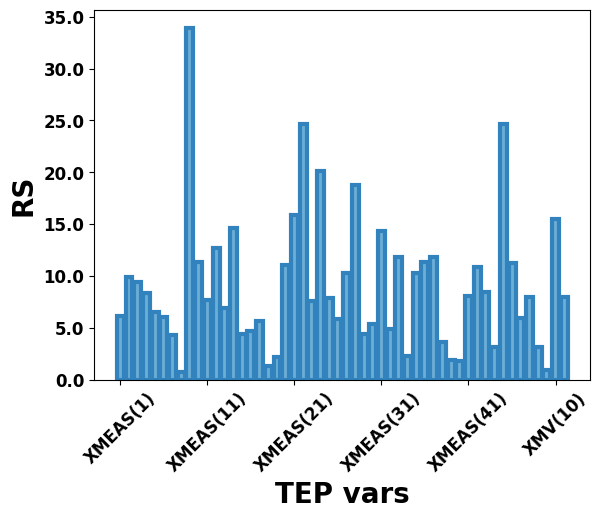

<Figure size 640x480 with 0 Axes>

In [ ]:

print(f1_rule.get_max_dev())
top_contrib,relevance_score=f1_rule.analyze_top_contrib_with_weight()
plt.figure()

xticks=np.arange(0,52,10)
xtick_labels=[columns[i] for i in xticks]

plt.bar(np.arange(len(relevance_score)),relevance_score,facecolor=colors(1),edgecolor=colors(0),linewidth=3)
ax=plt.gca()
ax.set_yticklabels(ax.get_yticks(),fontdict=ticks_fd)
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels,fontdict=xticks_fd)
plt.xlabel('TEP vars',fontdict=xlabels_fd)
plt.ylabel('RS',fontdict=ylabels_fd)
plt.figure()


In [ ]:
fault_type=21
n_tc=5
ex_var_thresh_perc=70

f_data=np.reshape(pf_time_series_no_overlap[fault_type],newshape=[-1,52])
f_data=butter_lowpass_filter(data=f_data,cutoff_frequency=0.01)
fl_rule_temp_ts=FaultLocRule(data=f_data,fault_type=fault_type,feature_names=tep_process_var_names,var_thresh=ex_var_thresh_perc)
fl_rule_temp_ts.fit()

idx=fault_type_l==fault_type
f_data=faults_pf_dev_info[idx,:]
fl_rule_temp_feat=FaultLocRule(data=f_data,fault_type=fault_type,feature_names=temp_res_feature_names,var_thresh=ex_var_thresh_perc)
fl_rule_temp_feat.fit()


#now plot the RS and compare
top_contrib_ts,RS_ts=fl_rule_temp_ts.analyze_top_contrib_with_weight(num_top_contrib=n_tc)
top_contrib_ts=top_contrib_ts+fl_rule_temp_ts.get_max_dev(num_top_contrib=3)

top_contrib_f,RS_f=fl_rule_temp_feat.analyze_top_contrib_with_weight(num_top_contrib=n_tc)
top_contrib_f=top_contrib_f+fl_rule_temp_feat.get_max_dev(num_top_contrib=3)

print("Based on the temp residual timeseries the top contributors are: {}".format(top_contrib_ts))
print("Based on the temp residual features the top contributors are   :{}".format(top_contrib_f))




Based on the temp residual timeseries the top contributors are: ['XMEAS(8)', 'XMV(10)', 'XMEAS(21)', 'XMEAS(25)', 'XMEAS(26)', 'XMEAS(8)']
Based on the temp residual features the top contributors are   :['XMEAS(8)-mu', 'XMV(10)-mu', 'XMEAS(25)-mu', 'XMEAS(21)-mu', 'XMEAS(26)-mu', 'XMEAS(5)-std', 'XMEAS(15)-std', 'XMV(8)-std']


In [ ]:
faults_2clus=[1,2,4,6,7,11,12,13,14,17,18,19,20,21]
for fault_type in faults_2clus:
    f_data=np.reshape(pf_time_series[fault_type],newshape=[-1,52])
    f_data=butter_lowpass_filter(data=f_data,cutoff_frequency=0.01)


    fi_rule=FaultLocRule(data=f_data,fault_type=fault_type, feature_names=temp_res_feature_names,var_thresh=70)
    fi_rule.fit()
    ex_var_perc,var_cs=fi_rule.analyze_var(75)
    fi_tc,_=fi_rule.analyze_top_contrib_with_weight(num_top_contrib=5)
    fi_tc_bias=fi_rule.get_max_dev(num_top_contrib=3)
    print("Fault {} top contributors: {} and {}".format(fault_type,fi_tc,fi_tc_bias))



Fault 1 top contributors: ['XMEAS(4)-mu', 'XMEAS(8)-mu', 'XMEAS(21)-mu', 'XMEAS(26)-mu', 'XMEAS(31)-mu'] and ['XMEAS(1)-mu', 'XMV(3)-mu', 'XMEAS(21)-mu']
Fault 2 top contributors: ['XMEAS(34)-mu', 'XMEAS(10)-mu', 'XMEAS(28)-mu', 'XMV(6)-mu', 'XMEAS(30)-mu'] and ['XMEAS(10)-mu', 'XMV(6)-mu', 'XMEAS(22)-mu']
Fault 4 top contributors: ['XMEAS(24)-mu', 'XMEAS(4)-mu', 'XMEAS(35)-mu', 'XMEAS(6)-mu', 'XMEAS(8)-mu'] and ['XMV(10)-mu', 'XMEAS(9)-mu']
Fault 6 top contributors: ['XMV(10)-mu', 'XMV(5)-mu', 'XMV(11)-mu', 'XMV(4)-mu', 'XMEAS(21)-mu'] and ['XMV(10)-mu', 'XMV(5)-mu', 'XMV(4)-mu']
Fault 7 top contributors: ['XMEAS(8)-mu', 'XMEAS(4)-mu', 'XMEAS(21)-mu', 'XMEAS(6)-mu', 'XMEAS(24)-mu'] and ['XMV(4)-mu', 'XMEAS(31)-mu', 'XMEAS(40)-mu']
Fault 11 top contributors: ['XMV(10)-mu', 'XMEAS(9)-mu', 'XMEAS(32)-mu', 'XMEAS(35)-mu', 'XMEAS(40)-mu'] and ['XMV(10)-mu']
Fault 12 top contributors: ['XMEAS(4)-mu', 'XMEAS(8)-mu', 'XMEAS(22)-mu', 'XMEAS(21)-mu', 'XMEAS(6)-mu'] and []
Fault 13 top contribut

In [ ]:
#in this notebook (faulty_as_dataset_l) contains the NOC data at the first index
#faults_2clus[2]
print(fault_type)
wrapper_model=lambda x: ss_mdl(x)[0]

pfi_time_series=np.reshape(pf_time_series[fault_type],newshape=[-1,52])
#pfi_time_series=filter_tep_timeseries(data=pfi_time_series,denoising_weight=2)
pfi_time_series=butter_lowpass_filter(data=pfi_time_series,cutoff_frequency=0.02)
_=lossmod.plot_tep_timeseris(data=pfi_time_series,ylims=[-5,5],process_vars_name=columns,fault_injection_sample=None)

21


TypeError: plot_tep_timeseris() missing 2 required positional arguments: 'data_labels' and 'data_colors'

<font size=5> Steps: (For each principal component) </font>:
1.  Sort the features in a decsnding order using the magnitude of the projection of the PC on each feature
2.  Report the features that yield over 90% contribution (<font color=teal> Note: np.sort returns a sorted array while np.argsort returns the indices that would sort the array </font>)
3.

<font size=6 color=teal> Checking if the principal components actually describe the cluster </font>
<font size=5> If, after clustering, the prinicpal components of each clsuter describe that cluster "uniquely", Then, the scores of the samples in that cluster should have a different distribution than all other clusters </font>
- I need a function that takes in all data and a set of PCs associated with one of the clusters. The function should return a 2-d plot showing the projection of all samples on the first two PCs. If the PCs are unique to the cluster, the samples belonging to that clsuter should be seprable from the rest of the data

In [ ]:
idx_red=[True if fault_type in faults_2clus else False for fault_type in fault_type_l]
faults_dev_info_red=faults_dev_info[idx_red]
fault_type_l_red=fault_type_l[idx_red]

In [ ]:
fault_type_l_red.shape

In [ ]:
def visualize_cluster_vs_all_pc_scores(data,data_type_info,cluster_type_list,cluster_pcs,quiver_flag=False):
    '''

    :param data: N x K dataset containing all samples (all clusters)
    :param data_type_info: a list storing integers to denote the cluster type
    :param cluster_type_list: a list of integers defining identity of the clusters being considered #TODO: For now I am limiting these to two
    :param cluster_pcs: K x K matrix storing the K principal components associated with "cluster_type" cluster
    :return:
    '''



    #get the first two PCs
    P=cluster_pcs[:,:2]
    #project the data on the space spanned by P
    scores=np.matmul(data,P)
    #get the indices of the samples belonging to cluster_type cluster
    colors=['blue','green']
    temp=[]
    for i,cluster_type in enumerate(cluster_type_list):
        idx= (data_type_info==cluster_type)
        #plot the scores and use color coding to differentiate between the cluster of interest and the rest of the clusters
        temp.append(idx)

    other_idx=[~ (i | j) for i,j in zip(temp[0],temp[-1])]
    plt.scatter(scores[other_idx,0],scores[other_idx,1],color='orange',label='other')

    quiver_sampling_freq=20

    for i,idx in enumerate(temp):
        diff=np.diff(scores[idx],axis=0)
        mag=np.sqrt(diff[:,0]**2+diff[:,1]**2)
        plt.scatter(scores[idx,0],scores[idx,1],color=colors[i],label='cluster '+str(cluster_type_list[i]))
        #print(type(idx))
        if quiver_flag:
            plt.quiver(scores[idx,0][0:-1:quiver_sampling_freq], scores[idx,1][0:-1:quiver_sampling_freq],  diff[0:-1:quiver_sampling_freq, 0]/mag[0:-1:quiver_sampling_freq], diff[0:-1:quiver_sampling_freq, 1]/mag[0:-1:quiver_sampling_freq])



    plt.legend()



In [ ]:

t=visualize_cluster_vs_all_pc_scores(data=faults_dev_info_red,data_type_info=fault_type_l_red,cluster_type_list=[7,14],cluster_pcs=f1_rule.pca.components_,quiver_flag=False)

In [ ]:
a=np.arange(1,101)
a[0:100:5]

In [ ]:
np.unique(fault_type_l_red)
faults_2clus

In [ ]:
dum=np.tile(np.arange(1,11),[2,1]).transpose()
np.diff(dum,axis=0).shape